Libraries

In [1]:
# Install pycocotools
#!pip install pycocotools

import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.optimizers import Adam
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy, MeanSquaredError
import random
from tensorflow.keras.metrics import Metric
import time

from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # all operations during training will be done with this precision (matrix mul...)
# speeds up training time and interference time





In [2]:
names_of_class= ["FLY", "NOPALM", "PAUSE", "UNDEFINED"]

def coco_to_center(coco_bbox):
    """
    Convert COCO format bbox [x, y, width, height] to center-based format [center_x, center_y, width, height].

    Args:
        coco_bbox (list or tuple): Bounding box in COCO format [x, y, width, height].

    Returns:
        list: Bounding box in center-based format [center_x, center_y, width, height].
    """
    x, y, width, height = coco_bbox
    center_x = x + width / 2
    center_y = y + height / 2
    return [center_x, center_y, width, height]

def center_to_coco(center_bbox):
    """
    Convert center-based format bbox [center_x, center_y, width, height] to COCO format [x, y, width, height].

    Args:
        center_bbox (list or tuple): Bounding box in center-based format [center_x, center_y, width, height].

    Returns:
        list: Bounding box in COCO format [x, y, width, height].
    """
    center_x, center_y, width, height = center_bbox
    x = center_x - width / 2
    y = center_y - height / 2
    return [x, y, width, height]

def plot_image_with_bbox(image, true_bbox, true_class, pred_bbox, pred_class, bbox_format="coco"):

    plt.figure(figsize=(6, 6))

    # Multiply by 255 to rescale the image to [0, 255] range
    image = image * 255  # Undo normalization

    # Ensure image is in the correct dtype (uint8) for display
    image = image.astype('uint8')

    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Convert bounding boxes based on the format
    if bbox_format == "center":
        true_bbox = center_to_coco(true_bbox)
        true_bbox = np.array(true_bbox, dtype=np.float16)
        pred_bbox = center_to_coco(pred_bbox)
        pred_bbox = np.array(pred_bbox, dtype=np.float16)

    # Draw the true bounding box if it exists
    if not (true_bbox == [0, 0, 0, 0]).all():
        x, y, w, h = true_bbox
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
        #plt.gca().add_patch(plt.Rectangle((x * 360, y * 240), w * 360, h * 240, linewidth=2, edgecolor='r', facecolor='none'))

    # Draw the predicted bounding box if it exists
    if not (pred_bbox == [0, 0, 0, 0]).all():
        x, y, w, h = pred_bbox
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none'))

    # Add title with both true and predicted class
    plt.title(f"True Class: {true_class} [{names_of_class[np.argmax(true_class)]}], Predicted Class: {pred_class}[{names_of_class[np.argmax(pred_class)]}]")
    print("IoU:", 1 - iou_loss(true_bbox, pred_bbox, "coco"))
    plt.show()

In [3]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# HYPERPARAMETERS

include_MIRROR = True
# - double the dataset by adding mirror images

bbox_format = "center" # "coco" - top left, "center" - center
# - do you want to use default COCO bbox format, or switch to Center bbox format that could potentially imrpove object detecting

include_MOVM = True

In [28]:
# Ova skripta učitava podatke i pretvara ih u format pogodan za treniranje

# Path to your COCO dataset files
annotations_path = "/content/drive/MyDrive/Colab Notebooks/FINAL_PALM/result.json"
images_path = "/content/drive/MyDrive/Colab Notebooks/FINAL_PALM"
if not os.path.exists(images_path):
    print(f"Image {images_path} does not exist!")

# Load COCO dataset
coco = COCO(annotations_path)

# Extract categories
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]
print("Categories:", category_names)
print()

# Load image and annotation data
image_ids = coco.getImgIds()
images = coco.loadImgs(image_ids)

# Prepare data for Palm and No Palm
data = []
for image_info in images: #[:int(len(images)/2)]:
    img_id = image_info['id']
    img_path = os.path.join(images_path, image_info['file_name'].replace("\\", "/"))
    movm_path2 = "movement\\" + image_info['file_name'].replace("images", "movement").split("-", 1)[1].replace(".png", "_movement.png")
    movm_path = os.path.join(images_path, movm_path2.replace("\\", "/"))

    # print("Image file name:", image_info['file_name'])
    # print("MOVM file name:", movm_path2)
    # print(f"Image path: {img_path}")
    # print(f"MOVM path: {movm_path}")
    # print()
    anns = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))

    # Check if Palm exists
    palm_annotations = [ann for ann in anns if (ann['category_id'] != 1)]
    if palm_annotations:
        for ann in palm_annotations:
            bbox = ann['bbox']  # [x, y, width, height]
            if bbox_format == "center":
              bbox = coco_to_center(bbox)
            width, height = Image.open(img_path).size

            # Add original data
            data.append({
                "image_path": img_path,
                "movement_path": movm_path,
                "label": ann['category_id'],  # FLY=0 or PAUSE=2 or UNDEFINED=3
                "bbox": bbox
            })

    else:
        # Add original "No Palm" data
        data.append({
            "image_path": img_path,
            "movement_path": movm_path,
            "label": 1,  # NOPALM=1
            "bbox": [0, 0, 0, 0]
        })


def preprocess_image(image_path, movm_path, bbox, img_size=(240, 360), flip_or_not=False): #(480, 720)

    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    movm_img = None

    if movm_path is not None:
      movm_img = cv2.imread(movm_path, cv2.IMREAD_GRAYSCALE)

      if movm_img is None:
        print(f"Warning: Image at {movm_path} could not be loaded.")
        return None, None, None

      # Resize and normalize the image to [0, 1]
      movm_img = cv2.resize(movm_img, (img_size[1], img_size[0])) / 255.0

      if flip_or_not:
        movm_img = cv2.flip(movm_img, 1)





    if img is None:
        print(f"Warning: Image at {image_path} could not be loaded.")
        return None, None, None

    # Resize and normalize the image to [0, 1]
    img = cv2.resize(img, (img_size[1], img_size[0])) / 255.0  # Note: width comes first in OpenCV resize

    # If Palm, normalize bounding box
    if bbox:
        h, w = img_size
        x, y, bw, bh = bbox
        #bbox = [x / w, y / h, bw / w, bh / h]  # Normalize to [0, 1]
    else:
        bbox = [0, 0, 0, 0]  # No bounding box for "No Palm"

    # Apply horizontal flip if requested
    if flip_or_not:
        img = cv2.flip(img, 1)  # Horizontal flip

        # Flip bounding box coordinates
        if bbox != [0, 0, 0, 0]:  # Only flip if there's a valid bounding box
            if bbox_format == "coco":
                #FLIP FOR COCO
                bbox = [
                    img_size[1] - (bbox[0] + bbox[2]),  # Flip x by mirroring x + width
                    bbox[1],                  # y remains the same
                    bbox[2],                  # Width remains the same
                    bbox[3]                   # Height remains the same
                ]
            elif bbox_format == "center":
                # FLIP FOR CENTER BASED BBOX
                bbox = [
                    img_size[1] - bbox[0],  # Flip x by mirroring x + width
                    bbox[1],                  # y remains the same
                    bbox[2],                  # Width remains the same
                    bbox[3]                   # Height remains the same
                ]
    # Cast bbox and label to float16
    bbox = np.array(bbox, dtype=np.float16)

    return img, movm_img, bbox







loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Categories: ['FLY', 'NOPALM', 'PAUSE', 'UNDEFINED']



In [93]:
# Učitavanje podataka, dijeljenje u train/test data, te na kraju definiranje arhitekture NN. (Nikako ne koristiti batchnormalization layer)
# S 2 slike (i MOVM) se učitava oko 12min prvi run


def data_generator(data, img_size=(240, 360), is_include_MOVM=False):
    images, movements, labels, bboxes = [], [], [], []
    for entry in data:
        img, movm_img, bbox = preprocess_image(entry['image_path'], entry['movement_path'] if include_MOVM else None, entry['bbox'], img_size, flip_or_not = False)
        if img is not None:
            images.append(img)
            movements.append(movm_img)
            labels.append(entry['label'])
            bboxes.append(bbox)

        if include_MIRROR:
          f_img, f_movm_img, f_bbox = preprocess_image(entry['image_path'], entry['movement_path'] if include_MOVM else None, entry['bbox'], img_size, flip_or_not = True)
          if img is not None:
              images.append(f_img)
              movements.append(f_movm_img)
              labels.append(entry['label'])
              bboxes.append(f_bbox)

    # Convert to numpy arrays and add channel dimension
    images = np.array(images, dtype=np.float16)[..., np.newaxis]

    if is_include_MOVM:
        movements = np.array(movements, dtype=np.float16)[..., np.newaxis]
        images = np.concatenate([images, movements], axis=-1)

    # Combine label and bbox for the output (first element is label, next 4 are bbox)
    outputs = []
    for label, bbox in zip(labels, bboxes):
        # Ensure bbox is a 4-element vector (x, y, width, height)
        assert len(bbox) == 4, f"Expected bbox to have 4 elements, got {len(bbox)}"

        # One-hot encode the label (for 4 classes)
        one_hot_label = np.eye(4)[label]

        # Combine the one-hot label with the bounding box
        output = np.concatenate([one_hot_label, bbox]).astype(np.float16)
        outputs.append(output)

    # Convert outputs to numpy array with dtype float16
    return images, np.array(outputs, dtype=np.float16)


###################################################

# Prepare training and testing data
IMG_SIZE = (240, 360)
data_sample = random.sample(data, 50)
X_all, y_all = data_generator(data_sample, IMG_SIZE, is_include_MOVM = include_MOVM)
#X_all, y_all = data_generator(data, IMG_SIZE, is_include_MOVM = include_MOVM)
#split train/test 70-30
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42, shuffle=True)

# Extract labels from y_all
labels = np.argmax(y_all[:, 0:4], axis=1)  # Axis 1 to find the index of the max value (which is 1)

# Count the occurrences of each label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")



print()
print(f"Training: {len(X_train)} instances, {len(y_train)} labels | Testing: {len(X_test)} instances, {len(y_test)} labels")
random_indices = random.sample(range(len(y_train)), 10)

# Print y_train and bbox_train for the selected instances
for idx in random_indices:
    print(f"Instance {idx}: Label = {y_train[idx]}")

print("\nX_train shape:", X_train.shape)  # Should be (N, 480, 720, 1)
print("y_train shape:", y_train.shape)  # Should be (N, 5), where 5 is [label, bbox_x, bbox_y, bbox_w, bbox_h]
print("X_test shape:", X_test.shape)  # Should be (N, 480, 720, 1)
print("y_test shape:", y_test.shape)  # Should be (N, 5), where 5 is [label, bbox_x, bbox_y, bbox_w, bbox_h]



# YOLO V1 NN
def build_model(input_shape, grid_size=7, num_classes=4, isMOVM = False):

    # without MOVM images
    if isMOVM == False:

        input_img = Input(shape=input_shape)

        # Convolutional Backbone
        x = Conv2D(64, (7, 7), strides=2, padding='same', activation=None)(input_img)
        #x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

        x = Conv2D(128, (3, 3), strides=1, padding='same', activation=None)(x)
        #x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

        x = Conv2D(64, (1, 1), strides=1, padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(128, (1, 1), strides=1, padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
        #x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

        # Concatination of convolutional info
        x = Flatten()(x)
        #x = GlobalAveragePooling2D()(x) ILI PROBAT global max pool!!!!
        #x = GlobalAveragePooling2D()(x)

        # This Fully connected layer will be used only by bbox pred head
        x = Dense(128, activation='relu')(x)

        # This Fully connected layer will be used only by classification head
        x_class = Dense(64, activation='relu')(x)
        #x_class = Dense(32, activation='relu')(x_class)

        # Bounding box predictions
        bbox_output = Dense(4, activation='relu', name='bbox_output')(x)

        # Class probabilities
        class_output = Dense(4, activation='softmax', name='class_output')(x_class)


        # Concatenate bbox and class probabilities into a single 8-element output
        output = tf.keras.layers.Concatenate(name='output')([class_output, bbox_output])

        model = models.Model(inputs=input_img, outputs=output)
        # model = Model(inputs=input_img, outputs=[class_output, combined_output])

    #with MOVM images
    else:
        input_img1 = Input(shape=input_shape, name="input_image1")  # Black-and-white image
        input_img2 = Input(shape=input_shape, name="input_image2")  # Difference image

        # Branch for input image 1
        x1 = Conv2D(64, (7, 7), strides=2, padding='same', activation=None)(input_img1)
        x1 = LeakyReLU(alpha=0.1)(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), strides=2)(x1)

        x1 = Conv2D(128, (3, 3), strides=1, padding='same', activation=None)(x1)
        x1 = LeakyReLU(alpha=0.1)(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), strides=2)(x1)

        # Branch for input image 2
        x2 = Conv2D(64, (7, 7), strides=2, padding='same', activation=None)(input_img2)
        x2 = LeakyReLU(alpha=0.1)(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), strides=2)(x2)

        x2 = Conv2D(128, (3, 3), strides=1, padding='same', activation=None)(x2)
        x2 = LeakyReLU(alpha=0.1)(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), strides=2)(x2)

        # Merge the features from both branches
        merged = tf.keras.layers.Concatenate()([x1, x2])
        #merged = tf.keras.layers.Add()([x1, x2])
        #merged = tf.keras.layers.Multiply()([x1, x2])

        x = Conv2D(64, (1, 1), strides=1, padding='same')(merged)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(128, (1, 1), strides=1, padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
        #x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

        # Concatination of convolutional info
        x = Flatten()(x)

        # This Fully connected layer will be used only by bbox pred head
        x = Dense(128, activation='relu')(x)

        # This Fully connected layer will be used only by classification head
        x_class = Dense(64, activation='relu')(x)
        #x_class = Dense(32, activation='relu')(x_class)

        # Class probabilities
        class_output = Dense(num_classes, activation='softmax', name='class_output')(x_class)


        # Bounding box predictions
        bbox_output = Dense(4, activation='relu', name='bbox_output')(x)


        # Concatenate bbox and class probabilities into a single 8-element output
        output = tf.keras.layers.Concatenate(name='output')([class_output, bbox_output])

        model = models.Model(inputs=[input_img1, input_img2], outputs=output)

    model.summary()
    return model

Label 0: 56 samples
Label 1: 12 samples
Label 2: 14 samples
Label 3: 18 samples

Training: 70 instances, 70 labels | Testing: 30 instances, 30 labels
Instance 57: Label = [  1.     0.     0.     0.   217.   132.5   39.8   60.28]
Instance 18: Label = [0. 1. 0. 0. 0. 0. 0. 0.]
Instance 26: Label = [  0.     0.     0.     1.   217.5  201.8   67.    50.34]
Instance 21: Label = [  1.     0.     0.     0.   143.   132.5   39.8   60.28]
Instance 28: Label = [  1.     0.     0.     0.    64.44 183.6   54.75 109.5 ]
Instance 44: Label = [ 1.    0.    0.    0.   93.8  93.8  24.45 34.7 ]
Instance 49: Label = [  0.     0.     0.     1.   146.9  157.1   17.27  24.88]
Instance 48: Label = [  0.     0.     0.     1.   135.5  132.2   38.34  26.64]
Instance 60: Label = [  1.     0.     0.     0.   243.6  155.5   57.12  23.39]
Instance 23: Label = [0. 1. 0. 0. 0. 0. 0. 0.]

X_train shape: (70, 240, 360, 2)
y_train shape: (70, 8)
X_test shape: (30, 240, 360, 2)
y_test shape: (30, 8)


In [8]:
# Ovo je najvažniji dio, odnosi se na treniranje neuronske mreže, definiranje njene optimizacije (loss funct.) i metrika da pratimo napredak kroz treniranje
# Nebi trebalo ništa mijenjati, eventualno epochs (koliko rundi treniranja) i learning rate (lr), ili izmjeniti samu arhitektutu NN u prethodnim dijelovima
# Loss function je kombinacija mse * iou
# TIP: ako u prvih 10-15 epocha IoU metric bude i dalje 0.0, onda prekini izvođenje koda i pokreni iznova, dok se ne pojavi bar neki broj u prvih 10 epocha

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
#tf.config.run_functions_eagerly(True)
#tf.data.experimental.enable_debug_mode()

classification_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# num_classes
def iou_loss(y_true, y_pred, bbox_format_rn=None):
    """
    Compute IoU Loss between true and predicted bounding boxes.
    y_true and y_pred are expected to be in the format [x, y, w, h].
    """
    if bbox_format_rn is None:
      bbox_format_rn=bbox_format

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    if bbox_format_rn == "center":
        # Convert center-based bbox [cx, cy, w, h] to corner-based bbox [x_min, y_min, x_max, y_max]
        y_true_x_min = y_true[..., 0] - y_true[..., 2] / 2
        y_true_y_min = y_true[..., 1] - y_true[..., 3] / 2
        y_true_x_max = y_true[..., 0] + y_true[..., 2] / 2
        y_true_y_max = y_true[..., 1] + y_true[..., 3] / 2

        y_pred_x_min = y_pred[..., 0] - y_pred[..., 2] / 2
        y_pred_y_min = y_pred[..., 1] - y_pred[..., 3] / 2
        y_pred_x_max = y_pred[..., 0] + y_pred[..., 2] / 2
        y_pred_y_max = y_pred[..., 1] + y_pred[..., 3] / 2

    elif bbox_format_rn == "coco":
        # For COCO format, use the bbox directly
        y_true_x_min = y_true[..., 0]
        y_true_y_min = y_true[..., 1]
        y_true_x_max = y_true[..., 0] + y_true[..., 2]
        y_true_y_max = y_true[..., 1] + y_true[..., 3]

        y_pred_x_min = y_pred[..., 0]
        y_pred_y_min = y_pred[..., 1]
        y_pred_x_max = y_pred[..., 0] + y_pred[..., 2]
        y_pred_y_max = y_pred[..., 1] + y_pred[..., 3]
    else:
        raise ValueError("Invalid bbox_format. Use 'coco' or 'center'.")

    # Intersection coordinates
    inter_x_min = tf.maximum(y_true_x_min, y_pred_x_min)
    inter_y_min = tf.maximum(y_true_y_min, y_pred_y_min)
    inter_x_max = tf.minimum(y_true_x_max, y_pred_x_max)
    inter_y_max = tf.minimum(y_true_y_max, y_pred_y_max)

    # Intersection area
    inter_area = tf.maximum(0.0, inter_x_max - inter_x_min) * tf.maximum(0.0, inter_y_max - inter_y_min)

    # Union area
    true_area = (y_true_x_max - y_true_x_min) * (y_true_y_max - y_true_y_min)
    pred_area = (y_pred_x_max - y_pred_x_min) * (y_pred_y_max - y_pred_y_min)
    union_area = true_area + pred_area - inter_area

    # IoU
    iou = inter_area / tf.maximum(union_area, 1e-10)  # Avoid division by zero

    # IoU Loss
    return 1 - iou

def total_loss(y_true, y_pred):


    # print("y_true shape:", y_true.shape)
    # print("y_pred shape:", y_pred.shape)

    # # # Print the first few elements of y_true and y_pred to inspect
    # tf.print("y_true values:", y_true)  # Only the first 5 elements
    # tf.print("y_pred values:", y_pred)  # Only the first 5 elements

    class_true = y_true[..., 0:4]
    bbox_true = y_true[..., 4:]

    class_pred = y_pred[..., 0:4]
    bbox_pred = y_pred[..., 4:]

    # Create a mask to separate Palm and No Palm
    class_mask = tf.cast(tf.logical_or( tf.argmax(class_true, axis=-1) == 0, tf.argmax(class_true, axis=-1) == 2), tf.float32)

    squared_errors = tf.square(bbox_true - bbox_pred)  # Shape: (batch_size, 4)

    # Per-sample loss (mean across bbox coordinates)
    per_sample_loss = tf.reduce_mean(squared_errors, axis=-1)  # Shape: (batch_size,)

    # Batch-level loss (mean across the batch)
    batch_loss = tf.reduce_mean(per_sample_loss)

    total_bbox_loss = batch_loss



    # For No Palm (label=0), only calculate class loss
    # For Palm (label=1), calculate both class and bbox loss
    abs_bbox_loss = total_bbox_loss * class_mask  # Apply mask to bbox loss (ignore bbox loss if NOPALM or UNDEFINED)


    class_true_labels = tf.argmax(class_true, axis=-1)
    classification_loss = classification_loss_fn(class_true_labels, class_pred)
    # classification_loss = tf.equal(class_true, class_pred)
    # classification_loss = tf.cast(classification_loss, tf.float32)

    # tf.print("class_true:", class_true)
    # tf.print("class_pred:", class_pred)
    # tf.print("classification_loss:", classification_loss, "\n")

    # IoU loss
    bbox_iou_loss = iou_loss(bbox_true, bbox_pred, bbox_format)
    bbox_iou_loss = bbox_iou_loss * class_mask

    # Total loss
    #return classification_loss**1.5 + (bbox_iou_loss+1)**2 * abs_bbox_loss #ZA MOVM
    #return 0 * classification_loss + bbox_iou_loss * abs_bbox_loss * 10/7 #OVA JE GOAT, al bez klasifikacije
    return 2 * classification_loss**2 + 1 * (bbox_iou_loss+1)**2 * abs_bbox_loss #BEZ MOVM



def iou_metric(y_true, y_pred):
    class_true = y_true[..., 0:4]
    bbox_true = y_true[..., 4:]
    bbox_pred = y_pred[..., 4:]
    iou = 1 - iou_loss(bbox_true, bbox_pred)  # Since `iou_loss` returns 1 - IoU

    # Apply the condition: if true class is 1 or 3, set IoU to 0
    condition = tf.logical_or(tf.argmax(class_true, axis=-1) == 1, tf.argmax(class_true, axis=-1) == 3)
    iou = tf.where(condition, 0.0, iou)

    return iou * (10/7) # -> *(10/7) zato jer 30% podataka class(NOPALM ili UNDEFINED) pa kvare statistiku za cca ovaj omjer

def class_accuracy(y_true, y_pred):

    class_true = y_true[..., 0:4]
    class_pred = y_pred[..., 0:4]


    # Compare the true class with the predicted class
    class_true_index = tf.cast(tf.argmax(class_true, axis=-1), tf.float32)
    class_pred_index = tf.cast(tf.argmax(class_pred, axis=-1), tf.float32)

    # Compare the predicted class index with the true class index
    correct_predictions = tf.equal(class_true_index, class_pred_index)

    # Calculate accuracy: the number of correct predictions divided by the total number of samples
    accuracy = tf.cast(correct_predictions, tf.float32)
    #accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy


def mse_metric(y_true, y_pred):
    """
    Custom MSE metric with conditional logic.
    If y_true[..., 0] is 1 or 3, the MSE for those samples is set to 0.
    """
    # Extract bounding box coordinates and cast to float32
    bbox_true = tf.cast(y_true[..., 4:], tf.float32)
    bbox_pred = tf.cast(y_pred[..., 4:], tf.float32)
    # bbox_true = tf.cast(y_true[..., 4:], tf.float32)
    # bbox_pred = tf.cast(y_pred[..., 4:], tf.float32)
    class_true = y_true[..., 0:4]

    # Compute squared differences
    mse_per_sample = tf.reduce_mean(tf.square(bbox_true - bbox_pred), axis=-1)

    # Condition: Set MSE to 0 for specific class labels
    condition = tf.logical_or(tf.argmax(class_true, axis=-1) == 1, tf.argmax(class_true, axis=-1) == 3)
    mse_per_sample = tf.where(condition, 0.0, mse_per_sample)

    # Return mean MSE across the batch
    return tf.reduce_mean(mse_per_sample) * (10/7) # -> *(10/7) zato jer 30% podataka class(NOPALM ili UNDEFINED) pa kvare statistiku za cca ovaj omjer



early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,               # Stop after 10 epochs of no improvement
    restore_best_weights=True, # Restore weights from the epoch with the best validation loss
    verbose=1                  # Print message when stopping
)

### GLOBAL AVG, no MOVM ################
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',  # You can change this to 'val_iou' or another metric
#     factor=2/3,          # Reduce learning rate by half
#     patience=5,          # Number of epochs to wait for improvement before reducing the LR
#     min_lr= 0.0000015, #1e-7          # Minimum learning rate
#     verbose=1
# )

# optimizer = Adam(learning_rate=0.0015)
# Glob avg pool: start lr from: 0.0015, stop lr: 0.00015, patience=5, factor=2/3, just one: 0.001
# Flatten: start lr: 0.000052, stop lr: 0.00000002, just_one: 0.000008
############################



## FLATTEN, no MOVM ################
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # You can change this to 'val_iou' or another metric
    factor=2/3,          # Reduce learning rate by half
    patience=3,          # Number of epochs to wait for improvement before reducing the LR
    min_lr= 0.00000002, #1e-7          # Minimum learning rate
    verbose=1
)

optimizer = Adam(learning_rate=0.000052) #optimizer = Adam(learning_rate=0.000032)
# Glob avg pool: start lr from: 0.0015, stop lr: 0.00015, patience=5, factor=2/3, just one: 0.001
# Flatten: start lr: 0.000052, stop lr: 0.00000002, just_one: 0.000008
###########################


# ### FLATTEN, + MOVM ################
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',  # You can change this to 'val_iou' or another metric
#     factor=0.8,          # Reduce learning rate by half
#     patience=3,          # Number of epochs to wait for improvement before reducing the LR
#     min_lr= 0.00000002, #1e-7          # Minimum learning rate
#     verbose=1
# )

# optimizer = Adam(learning_rate=0.000052) #optimizer = Adam(learning_rate=0.000032)
# # Glob avg pool: start lr from: 0.0015, stop lr: 0.00015, patience=5, factor=2/3, just one: 0.001
# # Flatten: start lr: 0.000052, stop lr: 0.00000002, just_one: 0.000008
# ############################

# BUILD MODEL
model = build_model((IMG_SIZE[0], IMG_SIZE[1], 1), isMOVM = include_MOVM)

model.compile(
    optimizer=optimizer,
    loss=total_loss,  # Using custom loss
    metrics=[
            class_accuracy,       # Tracks % of the total data that was correctly predicted
            iou_metric,           # Track average IoU across the epoch
            mse_metric           # Track Mean Squared Error (MSE)
    ]
)


# Train the model
history = model.fit(
    [X_train[..., 0], X_train[..., 1]] if include_MOVM else X_train,
    y_train,
    validation_data=([X_test[..., 0], X_test[..., 1]] if include_MOVM else X_test, y_test),  # y_test also contains the same structure
    epochs=150, #150, #50,
    batch_size=1,
    callbacks=[lr_scheduler, early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 240, 360, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 240, 360, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 120, 180, 64)   │          3,200 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 120, 180, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 60, 90, 64)     │              0 │ leaky_re_lu[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 60, 90, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 60, 90, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 45, 128)    │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 30, 45, 64)     │          8,256 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 30, 45, 64)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 45, 128)    │         73,856 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 30, 45, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 30, 45, 128)    │         16,512 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 30, 45, 128)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 30, 45, 128)    │        147,584 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 30, 45, 128)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 15, 22, 128)    │              0 │ leaky_re_lu_5[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 42240)          │              0 │ max_pooling2d_2[0][0]  │
├──────────────────────

 Total params: 5,739,144 (21.89 MB)

 Trainable params: 5,739,144 (21.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - class_accuracy: 0.1688 - iou_metric: 0.0180 - loss: 16140.0234 - mse_metric: 5661.9189 - val_class_accuracy: 0.1458 - val_iou_metric: 0.0332 - val_loss: 7599.5903 - val_mse_metric: 2587.9893 - learning_rate: 5.2000e-05
Epoch 2/150
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - class_accuracy: 0.1357 - iou_metric: 0.0278 - loss: 7676.4307 - mse_metric: 2602.9780 - val_class_accuracy: 0.1458 - val_iou_metric: 0.0597 - val_loss: 7042.1738 - val_mse_metric: 2406.0620 - learning_rate: 5.2000e-05
Epoch 3/150
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - class_accuracy: 0.2326 - iou_metric: 0.0289 - loss: 6516.5581 - mse_metric: 2232.0713 - val_class_accuracy: 0.1991 - val_iou_metric: 0.0348 - val_loss: 5144.0293 - val_mse_metric: 1825.3679 - learning_rate: 5.2000e-05
Epoch 4/150
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - class_accuracy: 0.3222 - iou_metric: 0.0397 - loss: 5399.5405 - mse_metric: 1928.0105 - val_class_accuracy: 0.4977

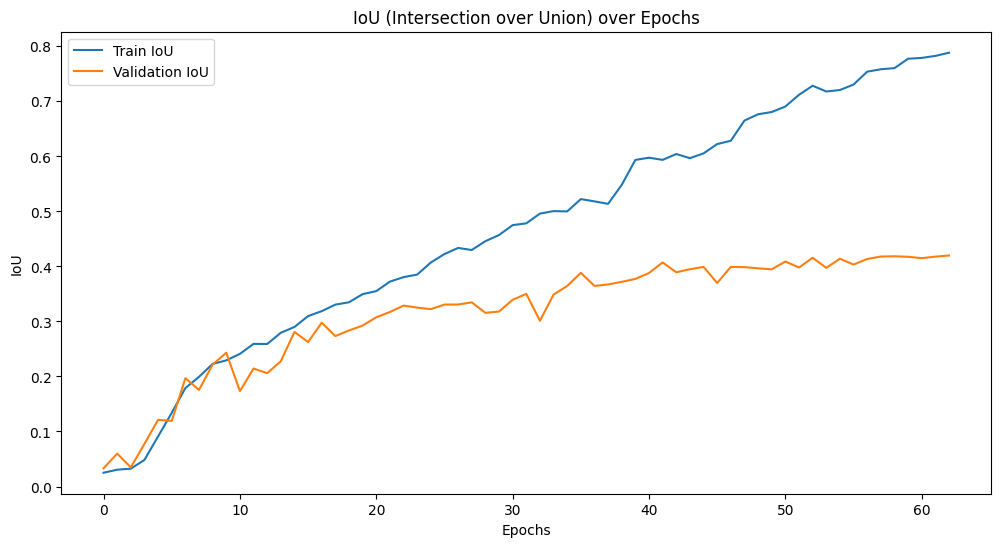

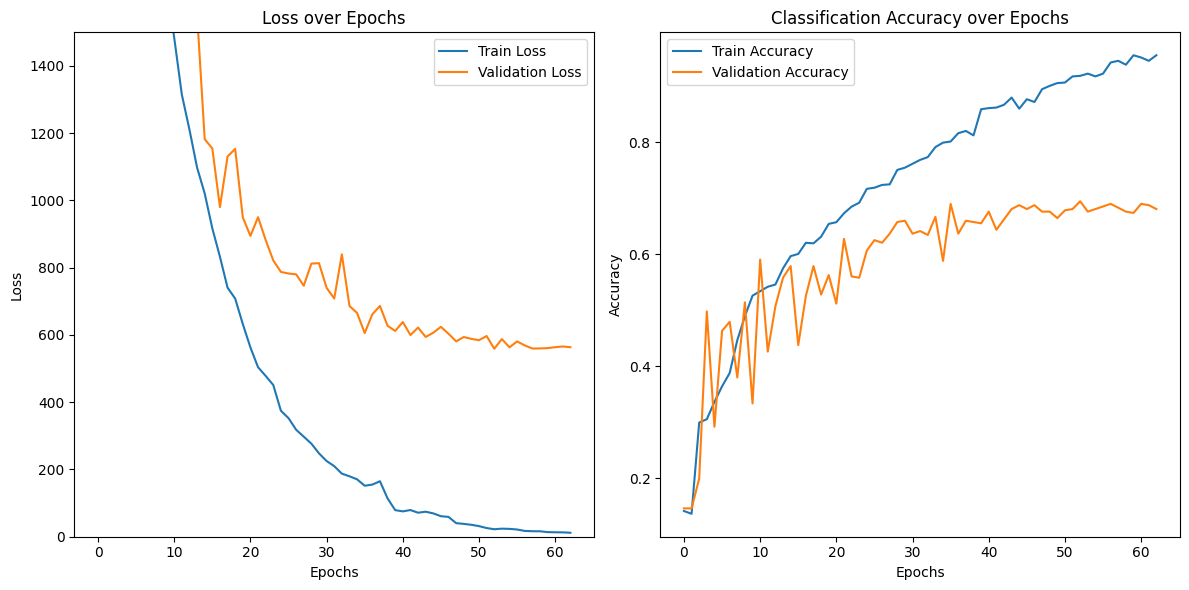

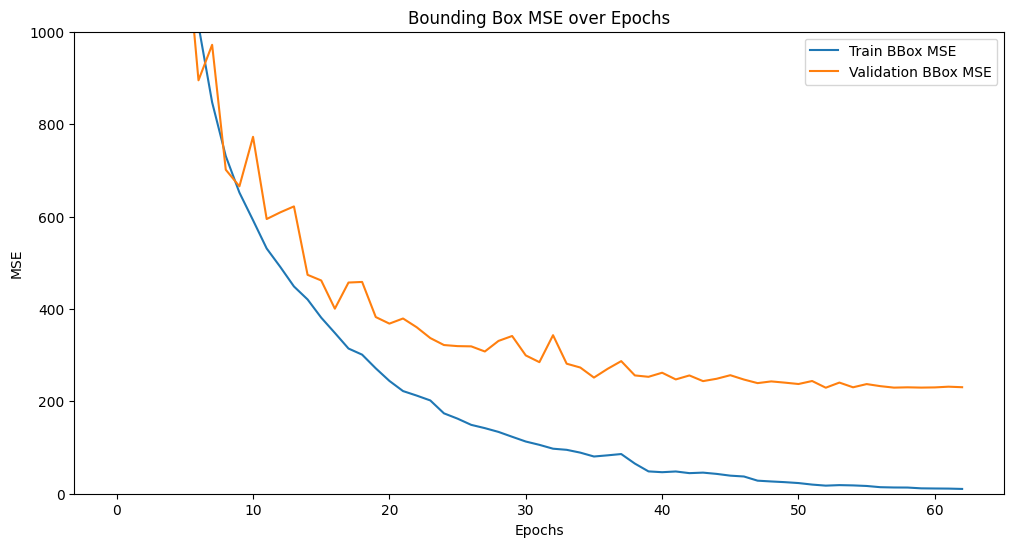

In [9]:
# Vizualizacija procesa treniranja

# Get the training and validation metrics from the history object
train_iou = history.history['iou_metric']
val_iou = history.history['val_iou_metric']

# Plot the IoU over epochs
plt.figure(figsize=(12, 6))
plt.plot(train_iou, label='Train IoU')
plt.plot(val_iou, label='Validation IoU')
plt.title('IoU (Intersection over Union) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_class_accuracy = history.history['class_accuracy']
val_class_accuracy = history.history['val_class_accuracy']

train_bbox_mse = history.history['mse_metric']
val_bbox_mse = history.history['val_mse_metric']

# Plot the loss over epochs
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1500)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_class_accuracy, label='Train Accuracy')
plt.plot(val_class_accuracy, label='Validation Accuracy')
plt.title('Classification Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Optionally, you can also plot the bounding box MSE
plt.figure(figsize=(12, 6))
plt.plot(train_bbox_mse, label='Train BBox MSE')
plt.plot(val_bbox_mse, label='Validation BBox MSE')
plt.title('Bounding Box MSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.ylim(0, 1000)
plt.show()

model.training = False


TEST
valid_indices num: 289
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
IoU: tf.Tensor(0.63063645, shape=(), dtype=float32)


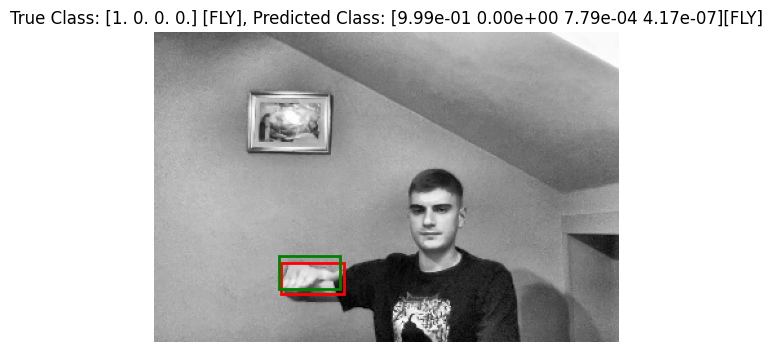

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
IoU: tf.Tensor(0.15156579, shape=(), dtype=float32)


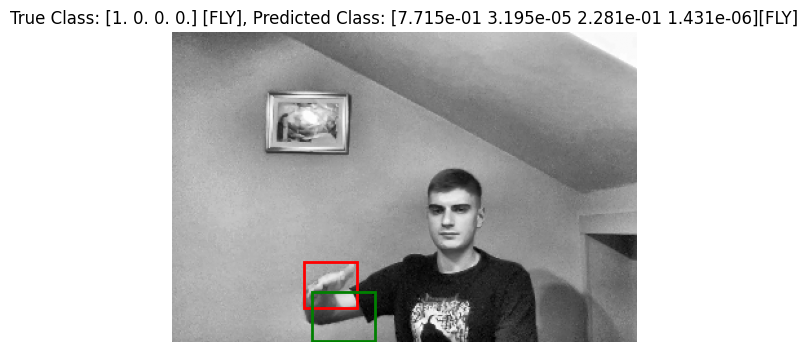

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
IoU: tf.Tensor(0.569454, shape=(), dtype=float32)


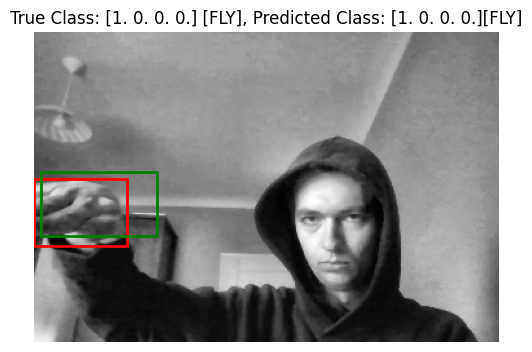

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
IoU: tf.Tensor(0.0, shape=(), dtype=float32)


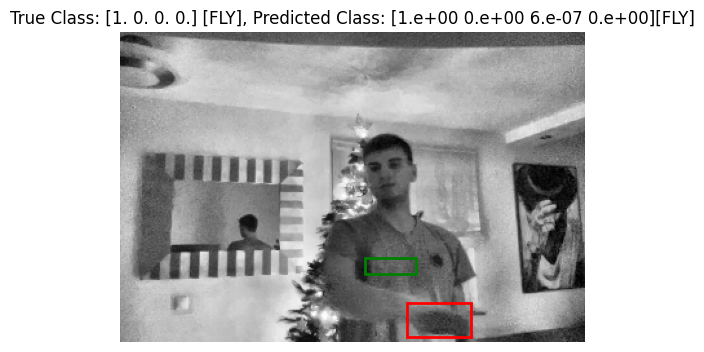

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
IoU: tf.Tensor(0.0, shape=(), dtype=float32)


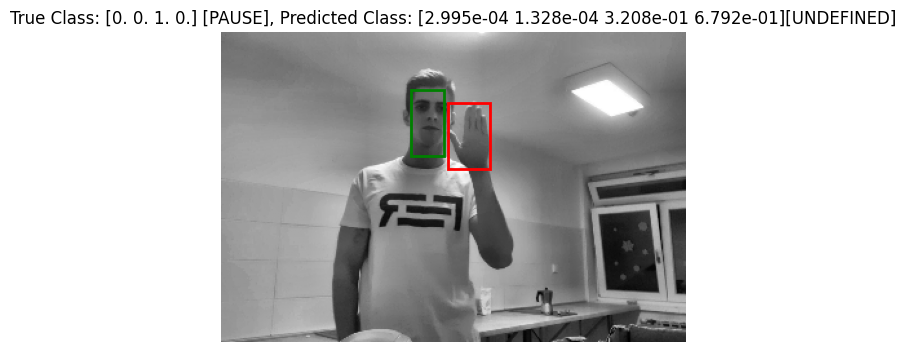

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
IoU: tf.Tensor(0.0, shape=(), dtype=float32)


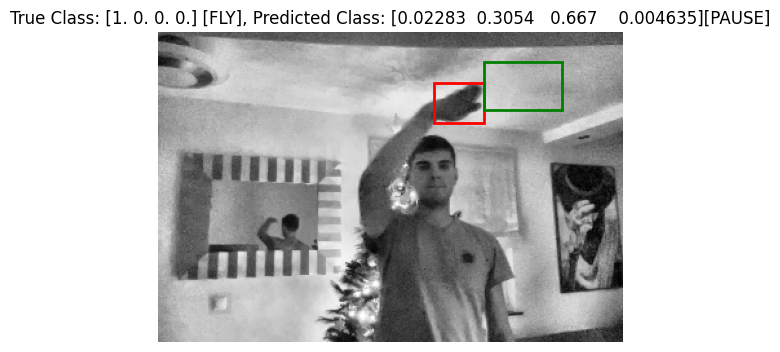

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
IoU: tf.Tensor(0.90829045, shape=(), dtype=float32)


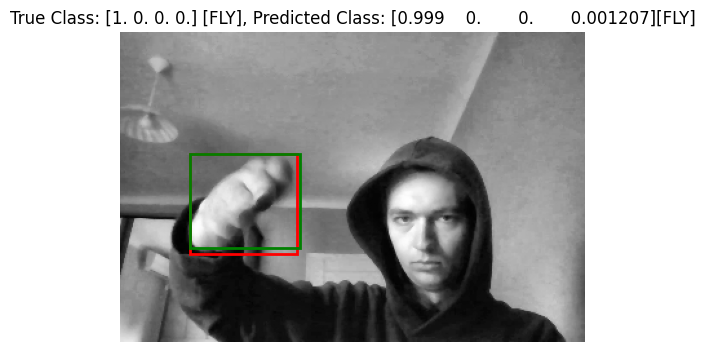

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
IoU: tf.Tensor(0.742827, shape=(), dtype=float32)


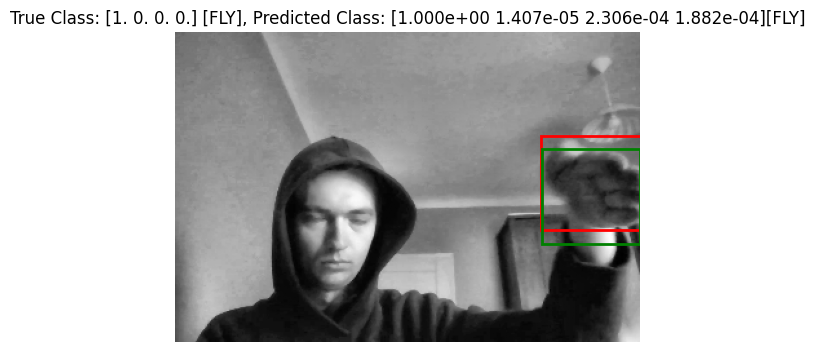

In [10]:
# Praktično testiranje kako radi trenirani model, predikcije su prave predikcije (našeg) treniranog modela
# Parametar which_one služi da se odabere želiš li testirati na treniranim podacima, ili na dosad neviđenim test podacima


which_one = "test" # "train" or "test"

if which_one == "test":
    print("TEST")

    # Select 8 random indices from the filtered indices
    valid_indices = [
        i for i, label in enumerate(y_test[..., 0:4])
        if np.argmax(label[0:4]) == 0 or np.argmax(label[0:4]) == 2
    ]
    print("valid_indices num:", len(valid_indices))
    random_indices = random.sample(valid_indices, 8)

    # Loop through the random samples
    for index in random_indices:
        # Get the image, true bounding box, and true class label
        true_bbox = y_test[index, 4:]  # Get bounding box (without label)
        true_class = y_test[index, 0:4]  # First element is the label (Palm or No Palm)

        if include_MOVM:
            image = X_test[index, ..., 0][np.newaxis, ..., np.newaxis]  # Prepare image for prediction
            image2 = X_test[index, ..., 1][np.newaxis, ..., np.newaxis]  # Prepare image for prediction
            pred_output = model.predict((image, image2), verbose=0)
            image = np.squeeze(image, axis=(0, -1))
        else:
            image = X_test[index, ..., 0]  # Get grayscale image (remove channel dimension)
            pred_output = model.predict(image[np.newaxis, ..., np.newaxis])  # Add batch and channel dimensions

        # Separate predicted class and bounding box from the model output
        pred_class = pred_output[0, 0:4]  # First element is the predicted class (Palm or No Palm)
        pred_bbox = pred_output[0, 4:]  # The remaining four elements are the predicted bounding box

        # Plot the image with both true and predicted bounding boxes
        plot_image_with_bbox(image, true_bbox, true_class, pred_bbox, pred_class, bbox_format=bbox_format)

elif which_one == "train":
    print("TRAIN")

    # Select 8 random indices from the filtered indices
    valid_indices = [
        i for i, label in enumerate(y_test[..., 0:4])
        if np.argmax(label[0:4]) == 0 or np.argmax(label[0:4]) == 2
    ]
    print("valid_indices num:", len(valid_indices))
    random_indices = random.sample(valid_indices, 8)

    # Loop through the random samples
    for index in random_indices:
        # Get the image, true bounding box, and true class label
        true_bbox = y_train[index, 4:]  # Get bounding box (without label)
        true_class = y_train[index, 0:4]  # First element is the label (Palm or No Palm)

        if include_MOVM:
            image = X_train[index, ..., 0][np.newaxis, ..., np.newaxis]  # Prepare image for prediction
            image2 = X_train[index, ..., 1][np.newaxis, ..., np.newaxis]  # Prepare image for prediction
            pred_output = model.predict((image, image2), verbose=0)
            image = np.squeeze(image, axis=(0, -1))
        else:
            image = X_train[index, ..., 0]  # Get grayscale image (remove channel dimension)
            pred_output = model.predict(image[np.newaxis, ..., np.newaxis])  # Add batch and channel dimensions

        # Separate predicted class and bounding box from the model output
        pred_class = pred_output[0, 0:4]  # First element is the predicted class (Palm or No Palm)
        pred_bbox = pred_output[0, 4:]  # The remaining four elements are the predicted bounding box

        # Plot the image with both true and predicted bounding boxes
        plot_image_with_bbox(image, true_bbox, true_class, pred_bbox, pred_class, bbox_format=bbox_format)






----- train -----
IoU:
Total analyzed samples: 695
Average IoU for JUST classes [0, 2] for dataset train: 0.7538
Standard Deviation of IoU for JUST classes [0, 2]: 0.1266

MSE:
Average MSE for JUST classes [0, 2] for dataset train: 16.3581
Standard Deviation of MSE for JUST classes [0, 2]: 15.4173

Average TIME for PREDICTION dataset train: 0.0347 s


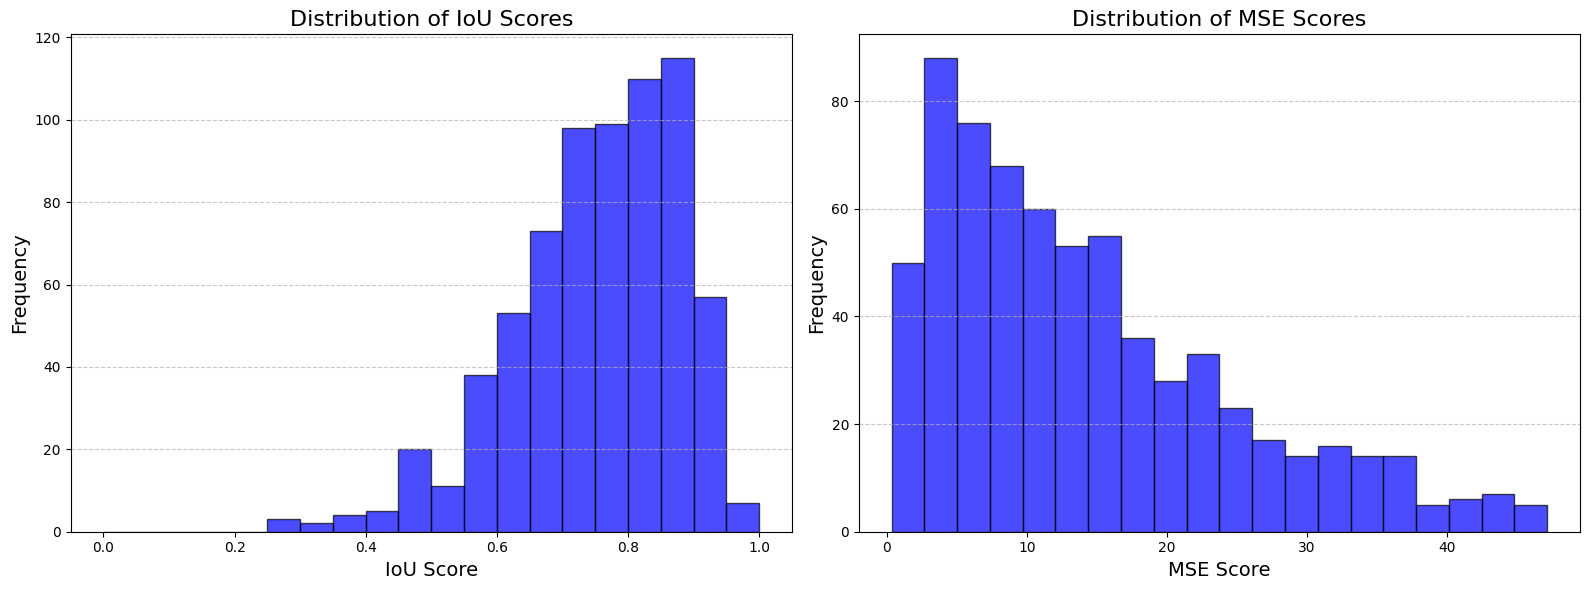




----- test -----
IoU:
Total analyzed samples: 289
Average IoU for JUST classes [0, 2] for dataset test: 0.4351
Standard Deviation of IoU for JUST classes [0, 2]: 0.2789

MSE:
Average MSE for JUST classes [0, 2] for dataset test: 240.1180
Standard Deviation of MSE for JUST classes [0, 2]: 380.3149

Average TIME for PREDICTION dataset test: 0.0349 s


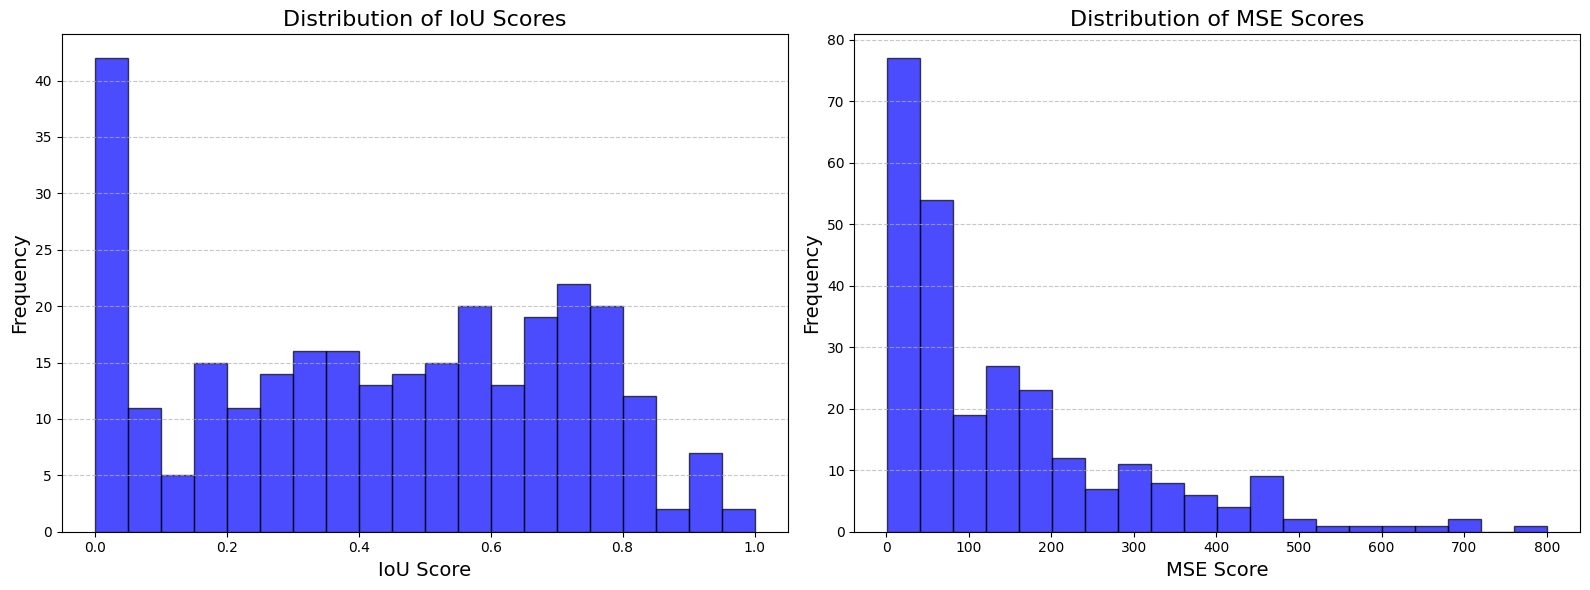

In [11]:
# Detaljna evaluacija IOU i MSE metrike (i TRAIN i TEST data)

def calculate_iou_mse_scores(dataset, model, class_filter, bbox_format_rn=None):
    """
    Calculate MSE scores for samples in the dataset where the class is in class_filter.

    Args:
    - dataset: Tuple (X, y) where X contains images and y contains labels and bounding boxes.
    - model: The trained model to make predictions.
    - class_filter: List of class labels to include in the MSE calculation (e.g., [0, 2]).
    - bbox_format_rn: Bounding box format, e.g., 'center' or 'coco'. Default is None.

    Returns:
    - mse_scores: List of MSE scores for the filtered dataset.
    """
    X, y = dataset
    iou_just_0_2 = []
    mse_just_0_2 = []
    total_time = 0

    for i in range(len(X)):
        true_class = y[i, 0:4]  # Get the class label
        true_class = np.argmax(true_class)
        if true_class in class_filter:

            # Get true bounding box
            true_bbox = y[i, 4:]  # Bounding box (without label)

            # Predict bounding box and class
            if include_MOVM:
              image1 = X[i, ..., 0][np.newaxis, ..., np.newaxis]  # Prepare image for prediction
              image2 = X[i, ..., 1][np.newaxis, ..., np.newaxis]  # Prepare image for prediction
              start_time = time.time()
              pred_output = model.predict((image1, image2), verbose=0)
              end_time = time.time() - start_time
            else:
              image = X[i, ..., 0][np.newaxis, ..., np.newaxis]  # Prepare image for prediction
              start_time = time.time()
              pred_output = model.predict(image, verbose=0)
              end_time = time.time() - start_time
            total_time += end_time

            pred_bbox = pred_output[0, 4:]  # Extract predicted bounding box

            # Calculate MSE (Mean Squared Error)
            mse = np.mean((true_bbox - pred_bbox) ** 2)  # MSE between true and predicted bounding box
            if (mse > 1e6):
              print("pred output:", pred_output)
              print("mse0", mse)
              print()

            mse_just_0_2.append(float(mse))

            # Calculate IoU
            iou = 1 - iou_loss(true_bbox[np.newaxis, ...], pred_bbox[np.newaxis, ...], bbox_format_rn)
            iou_just_0_2.append(float(iou))

    return iou_just_0_2, mse_just_0_2, total_time/len(X)


def plot_distributions(iou_scores, mse_scores):

    # Calculate min and max for MSE x-axis limits
    min_mse = min(mse_scores)
    max_mse = max(mse_scores)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # IoU distribution plot
    axes[0].hist(iou_scores, bins=20, range=(0, 1), color='blue', alpha=0.7, edgecolor='black')
    axes[0].set_title('Distribution of IoU Scores', fontsize=16)
    axes[0].set_xlabel('IoU Score', fontsize=14)
    axes[0].set_ylabel('Frequency', fontsize=14)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # MSE distribution plot
    axes[1].hist(mse_scores, bins=20, range=(min_mse, max_mse*0.3), color='blue', alpha=0.7, edgecolor='black')
    axes[1].set_title('Distribution of MSE Scores', fontsize=16)
    axes[1].set_xlabel('MSE Score', fontsize=14)
    axes[1].set_ylabel('Frequency', fontsize=14)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()




for which_one in ["train", "test"]:
    print("\n\n")
    print("-----", which_one,  "-----")

    if which_one == "test":
        dataset = (X_test, y_test)
    elif which_one == "train":
        dataset = (X_train, y_train)

    class_filter = [0, 2]  # Include only classes 0 and 2
    iou_just_0_2, mse_just_0_2, avg_time = calculate_iou_mse_scores(dataset, model, class_filter, bbox_format_rn=bbox_format)


    # IOU
    avg_iou = np.mean(iou_just_0_2)
    std_iou = np.std(iou_just_0_2)  # Standard deviation of IoU
    total_samples = len(iou_just_0_2)
    print("IoU:")
    print("Total analyzed samples:", total_samples)
    print(f"Average IoU for JUST classes {class_filter} for dataset {which_one}: {avg_iou:.4f}")
    print(f"Standard Deviation of IoU for JUST classes {class_filter}: {std_iou:.4f}")

    # MSE
    avg_mse = np.mean(mse_just_0_2)
    std_mse = np.std(mse_just_0_2)  # Standard deviation of MSE
    print("\nMSE:")
    print(f"Average MSE for JUST classes {class_filter} for dataset {which_one}: {avg_mse:.4f}")
    print(f"Standard Deviation of MSE for JUST classes {class_filter}: {std_mse:.4f}")
    print()


    print(f"Average TIME for PREDICTION dataset {which_one}: {avg_time:.4f} s")



    # Plot IoU and MSE distributions side by side
    plot_distributions(iou_just_0_2, mse_just_0_2)

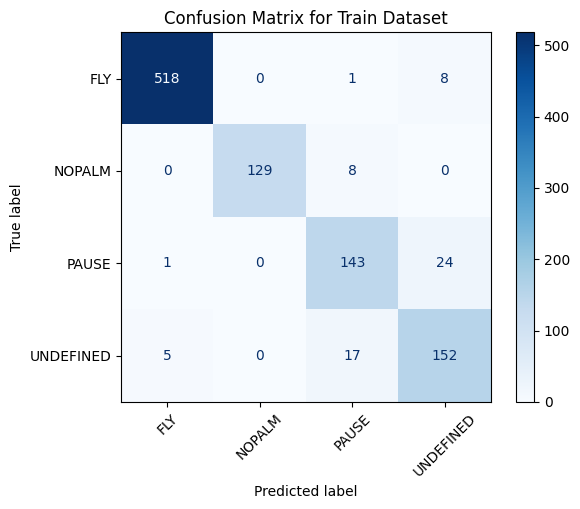

----- Metrics for Train Dataset -----
Accuracy: 0.9364

Classification Report:
              precision    recall  f1-score   support

         FLY       0.99      0.98      0.99       527
      NOPALM       1.00      0.94      0.97       137
       PAUSE       0.85      0.85      0.85       168
   UNDEFINED       0.83      0.87      0.85       174

    accuracy                           0.94      1006
   macro avg       0.92      0.91      0.91      1006
weighted avg       0.94      0.94      0.94      1006



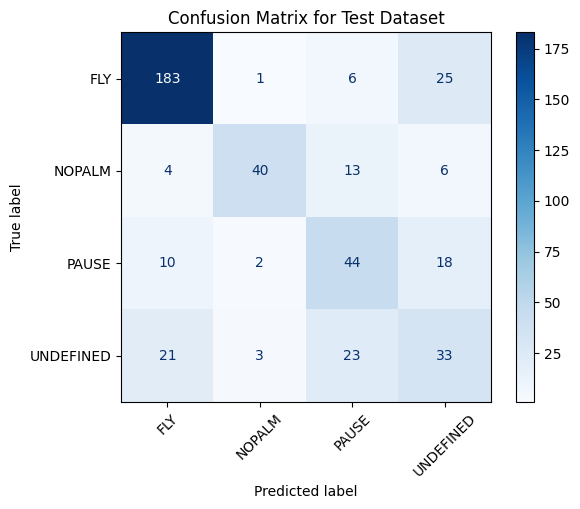

----- Metrics for Test Dataset -----
Accuracy: 0.6944

Classification Report:
              precision    recall  f1-score   support

         FLY       0.84      0.85      0.85       215
      NOPALM       0.87      0.63      0.73        63
       PAUSE       0.51      0.59      0.55        74
   UNDEFINED       0.40      0.41      0.41        80

    accuracy                           0.69       432
   macro avg       0.66      0.62      0.63       432
weighted avg       0.71      0.69      0.70       432



In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

def process_dataset(dataset, model):
    """
    Process the dataset to get true and predicted classes.
    Args:
        dataset: Tuple of (X, y), where X is the input data and y contains the labels.
        model: Trained model to predict outputs.
    Returns:
        all_true_classes: Array of true class indices.
        all_pred_classes: Array of predicted class indices.
    """
    X, y = dataset
    all_true_classes = []
    all_pred_classes = []

    for i in range(len(X)):
        true_class = y[i, 0:4]  # Get the class label
        true_class = np.argmax(true_class)
        all_true_classes.append(true_class)

        # Predict bounding box and class
        image = X[i, ..., 0][np.newaxis, ..., np.newaxis]  # Prepare image for prediction
        pred_output = model.predict(image, verbose=0)
        pred_class = pred_output[0, 0:4]  # Extract predicted class probabilities

        pred_class = np.argmax(pred_class)
        all_pred_classes.append(pred_class)

    return np.array(all_true_classes), np.array(all_pred_classes)

def plot_confusion_matrix(y_true, y_pred, names_of_class, dataset_name="Dataset"):
    """
    Computes and plots the confusion matrix with class names.
    Args:
        y_true: True class labels.
        y_pred: Predicted class labels.
        names_of_class: List of class names.
        dataset_name: Name of the dataset for labeling the plot.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names_of_class)

    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.show()

def print_metrics(y_true, y_pred, names_of_class, dataset_name="Dataset"):
    """
    Prints additional metrics like classification report and accuracy.
    Args:
        y_true: True class labels.
        y_pred: Predicted class labels.
        names_of_class: List of class names.
        dataset_name: Name of the dataset for labeling metrics.
    """
    print(f"----- Metrics for {dataset_name} -----")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=names_of_class))

def process_and_plot(data, model, names_of_class, dataset_name="Dataset"):
    """
    Processes the dataset, plots the confusion matrix, and prints additional metrics.
    Args:
        data: Tuple of (X, y), where X is the input data and y contains the labels.
        model: Trained model to predict outputs.
        names_of_class: List of class names.
        dataset_name: Name of the dataset for labeling the outputs.
    """
    # Process the dataset to extract true and predicted labels
    y_true, y_pred = process_dataset(data, model)

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, names_of_class, dataset_name)

    # Print additional metrics
    print_metrics(y_true, y_pred, names_of_class, dataset_name)

# Example usage
names_of_class = ["FLY", "NOPALM", "PAUSE", "UNDEFINED"]
process_and_plot((X_train, y_train), model, names_of_class, dataset_name="Train Dataset")
process_and_plot((X_test, y_test), model, names_of_class, dataset_name="Test Dataset")


In [ ]:
# calculate mAP?

In [18]:
# # Save the model, kasnije se može importat
# model.save("test_model_val_0.43_240.h5")
# # Save the model in the SavedModel format
# model.save('test_model_val_0.43_240.keras')


model.save_weights('weights_test_model_val_0.43_240.weights.h5')


**TESTING FOR KUT**

In [30]:
## TEST LOADING MODEL

input_shape = (240, 360, 1)  # Define the input shape based on your data
model2 = build_model(input_shape, isMOVM = False)
model_weights_path = "/content/weights_test_model_val_0.43_240.weights.h5"

# Load the saved weights into model2
model2.load_weights(model_weights_path)




Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 240, 360, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_18 (Cast)            │ (None, 240, 360, 1)    │              0 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, 120, 180, 64)   │          3,200 │ cast_18[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_108           │ (None, 120, 180, 64)   │              0 │ conv2d_108[0][0]       │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_54          │ (None, 60, 90, 64)     │              0 │ leaky_re_lu_108[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_109 (Conv2D)       │ (None, 60, 90, 128)    │         73,856 │ max_pooling2d_54[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_109           │ (None, 60, 90, 128)    │              0 │ conv2d_109[0][0]       │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_55          │ (None, 30, 45, 128)    │              0 │ leaky_re_lu_109[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_110 (Conv2D)       │ (None, 30, 45, 64)     │          8,256 │ max_pooling2d_55[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_110           │ (None, 30, 45, 64)     │              0 │ conv2d_110[0][0]       │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_111 (Conv2D)       │ (None, 30, 45, 128)    │         73,856 │ leaky_re_lu_110[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_111           │ (None, 30, 45, 128)    │              0 │ conv2d_111[0][0]       │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_112 (Conv2D)       │ (None, 30, 45, 128)    │         16,512 │ leaky_re_lu_111[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_112           │ (None, 30, 45, 128)    │              0 │ conv2d_112[0][0]       │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_113 (Conv2D)       │ (None, 30, 45, 128)    │        147,584 │ leaky_re_lu_112[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_113      

 Total params: 5,739,144 (21.89 MB)

 Trainable params: 5,739,144 (21.89 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
!pip install mediapipe opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 20.0 MB/s eta 0:00:00


Angle LR: 168.57531065679078° or 348.57531065679075°
No hands detected for image 1!


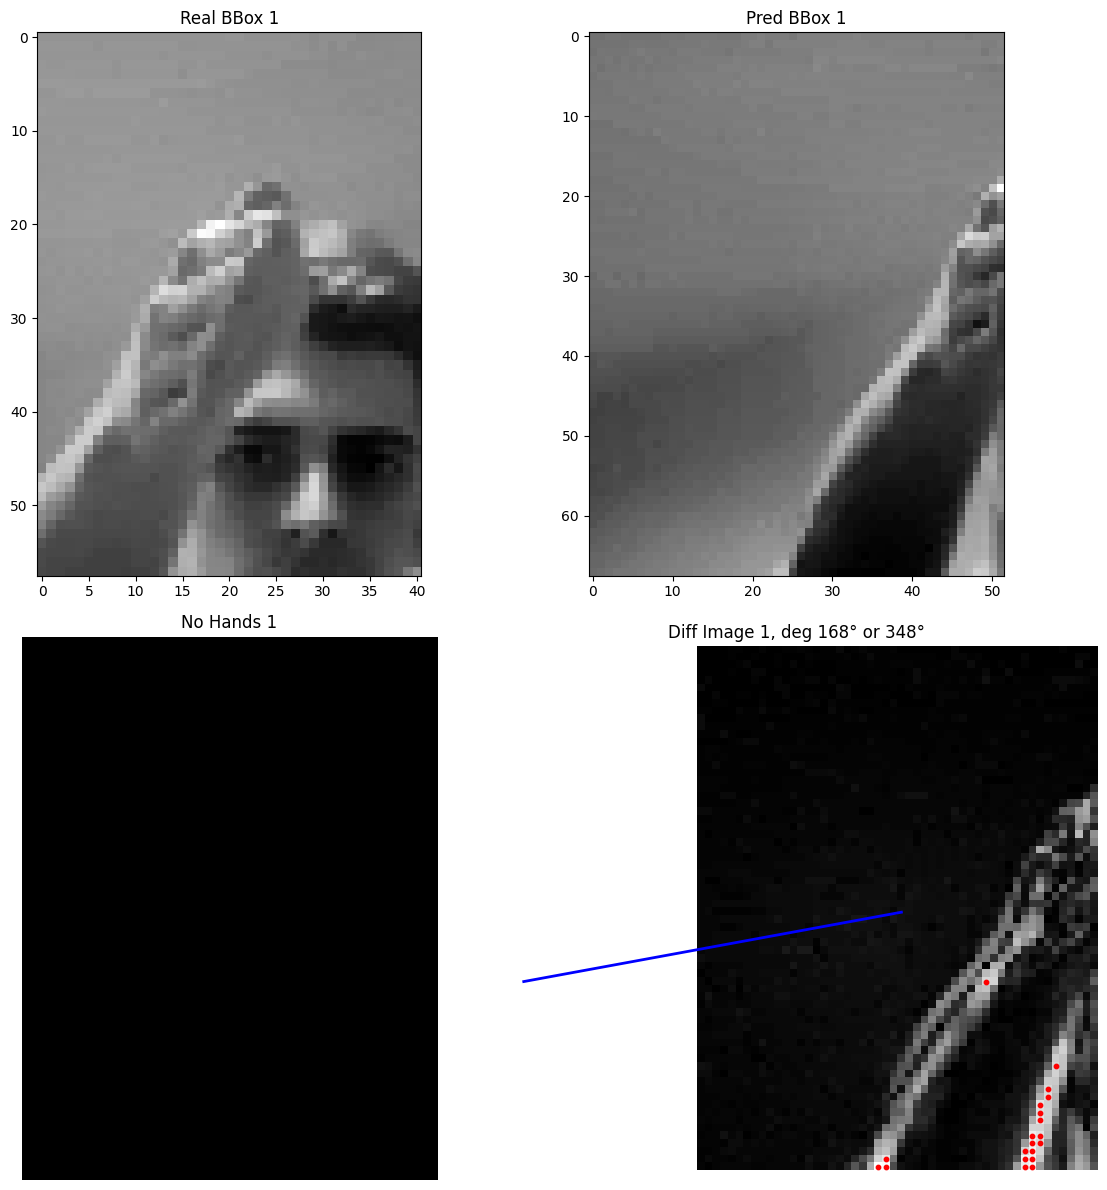

Angle LR: 10.699971291935492° or 190.6999712919355°
Hands detected for image 2!
Angle GOOGLE: 74°


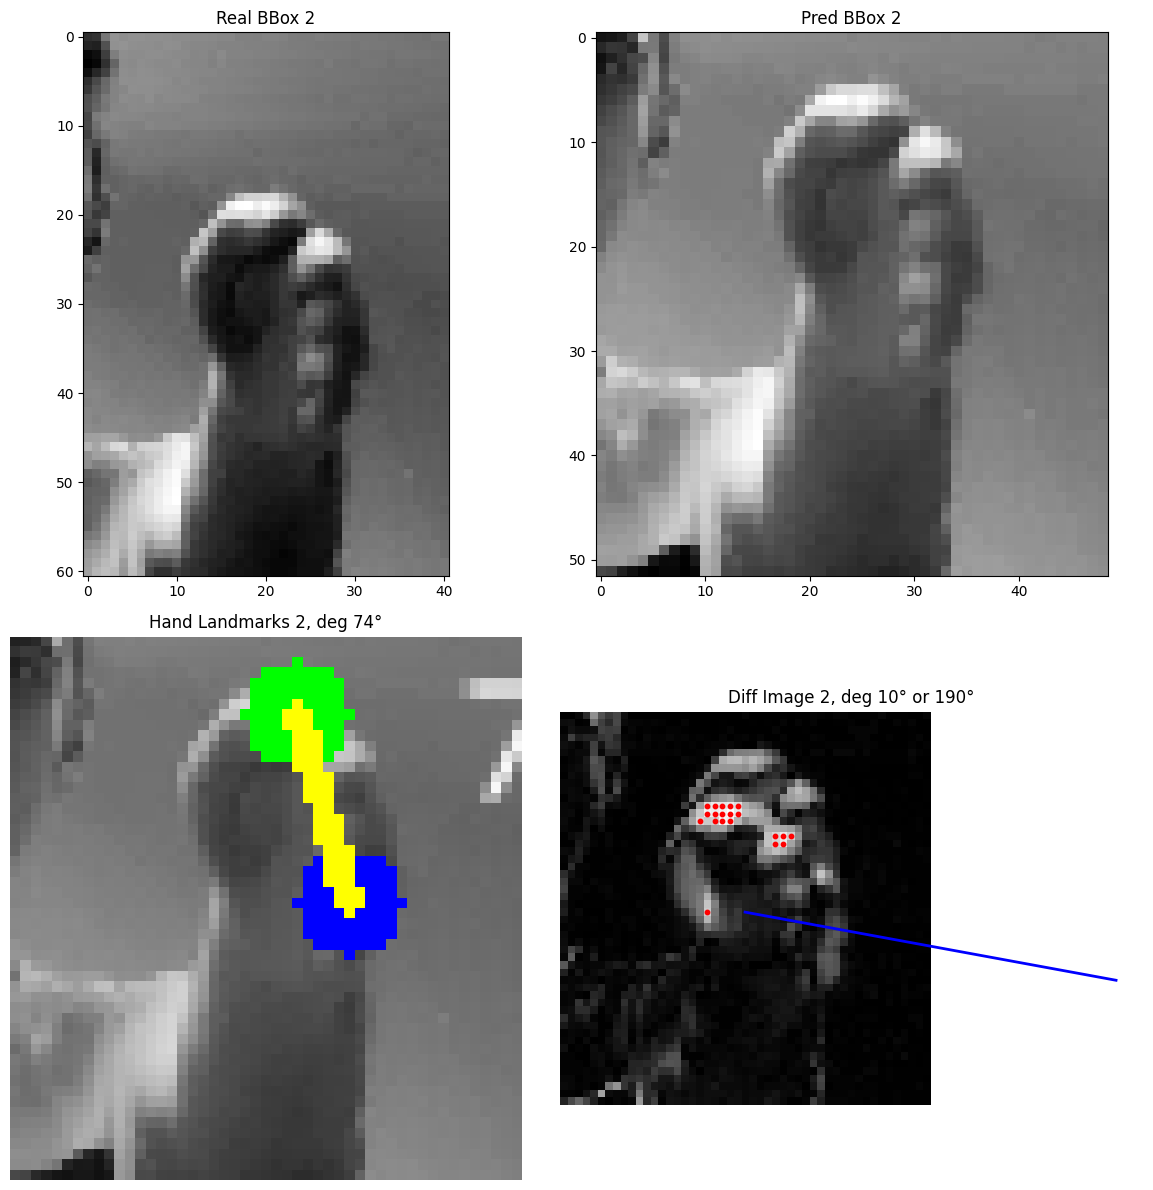

Angle LR: 2.071427083419081° or 182.07142708341908°
Hands detected for image 3!
Angle GOOGLE: 332°


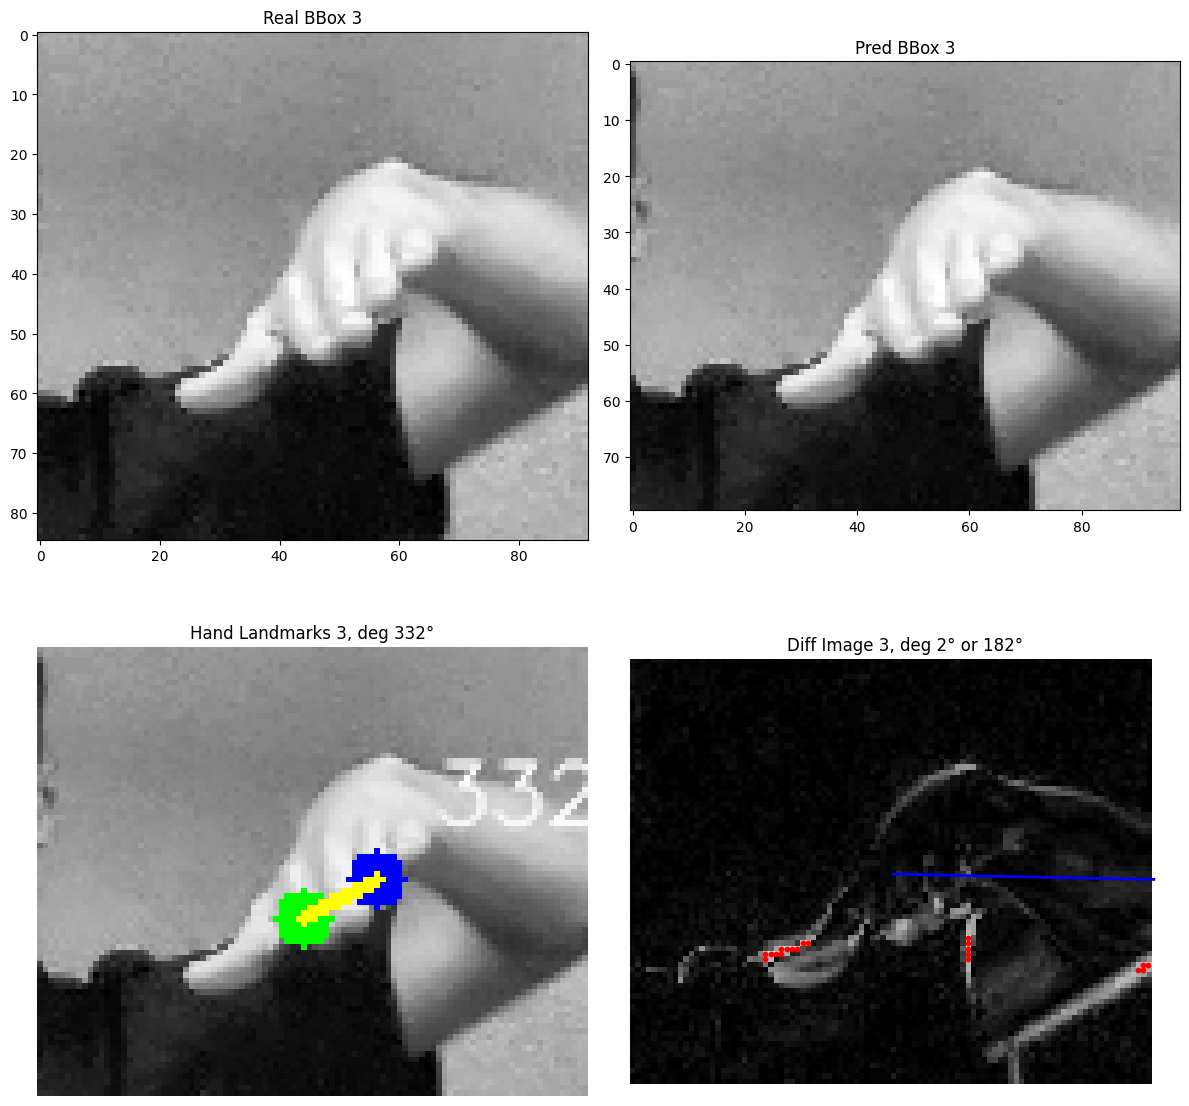

Angle LR: 177.43556402183268° or 357.43556402183265°
Hands detected for image 4!
Angle GOOGLE: 219°


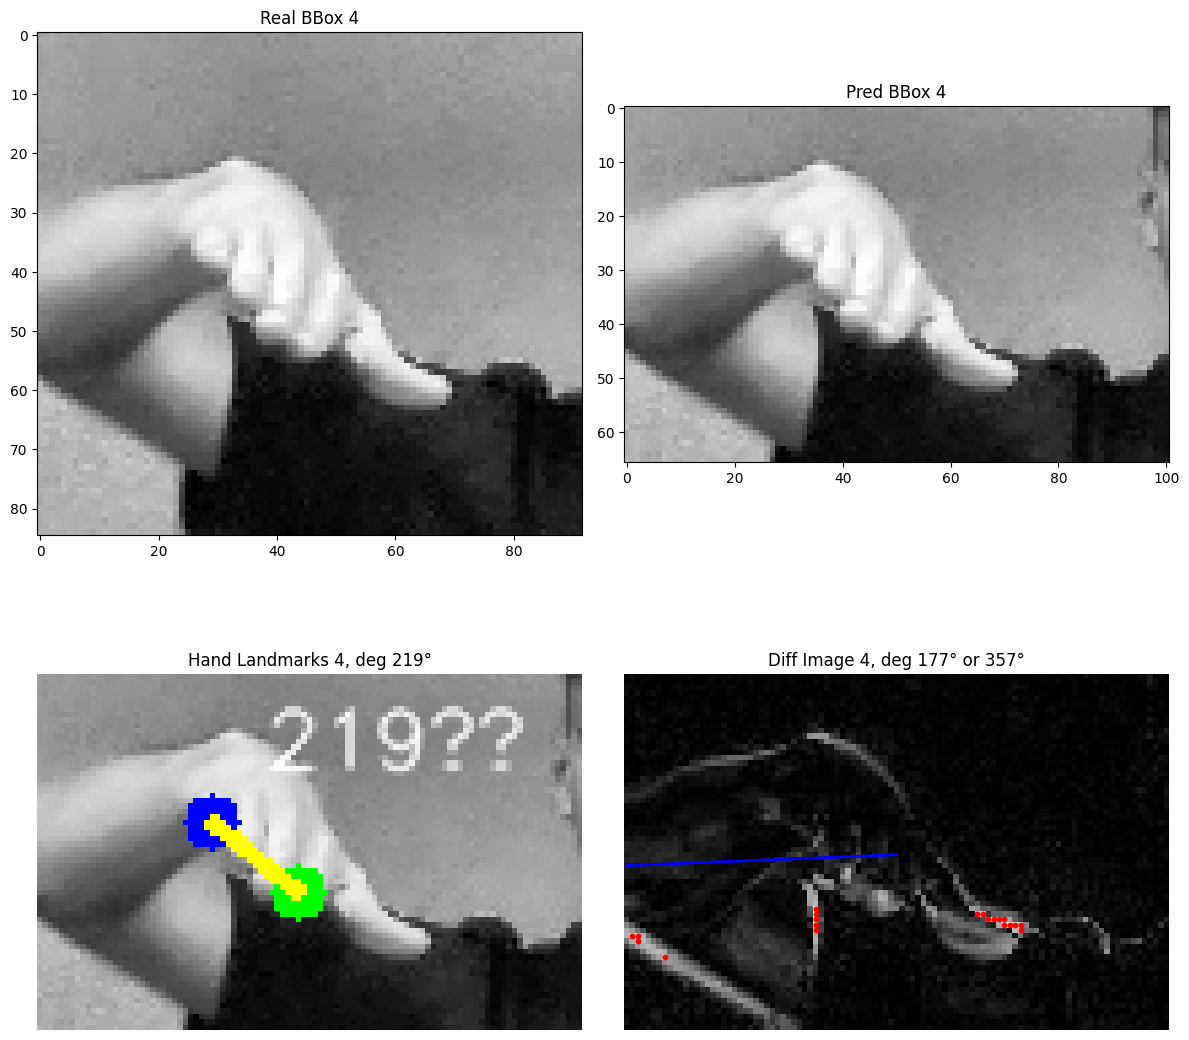

Angle LR: 102.38915544590537° or 282.3891554459054°
No hands detected for image 5!


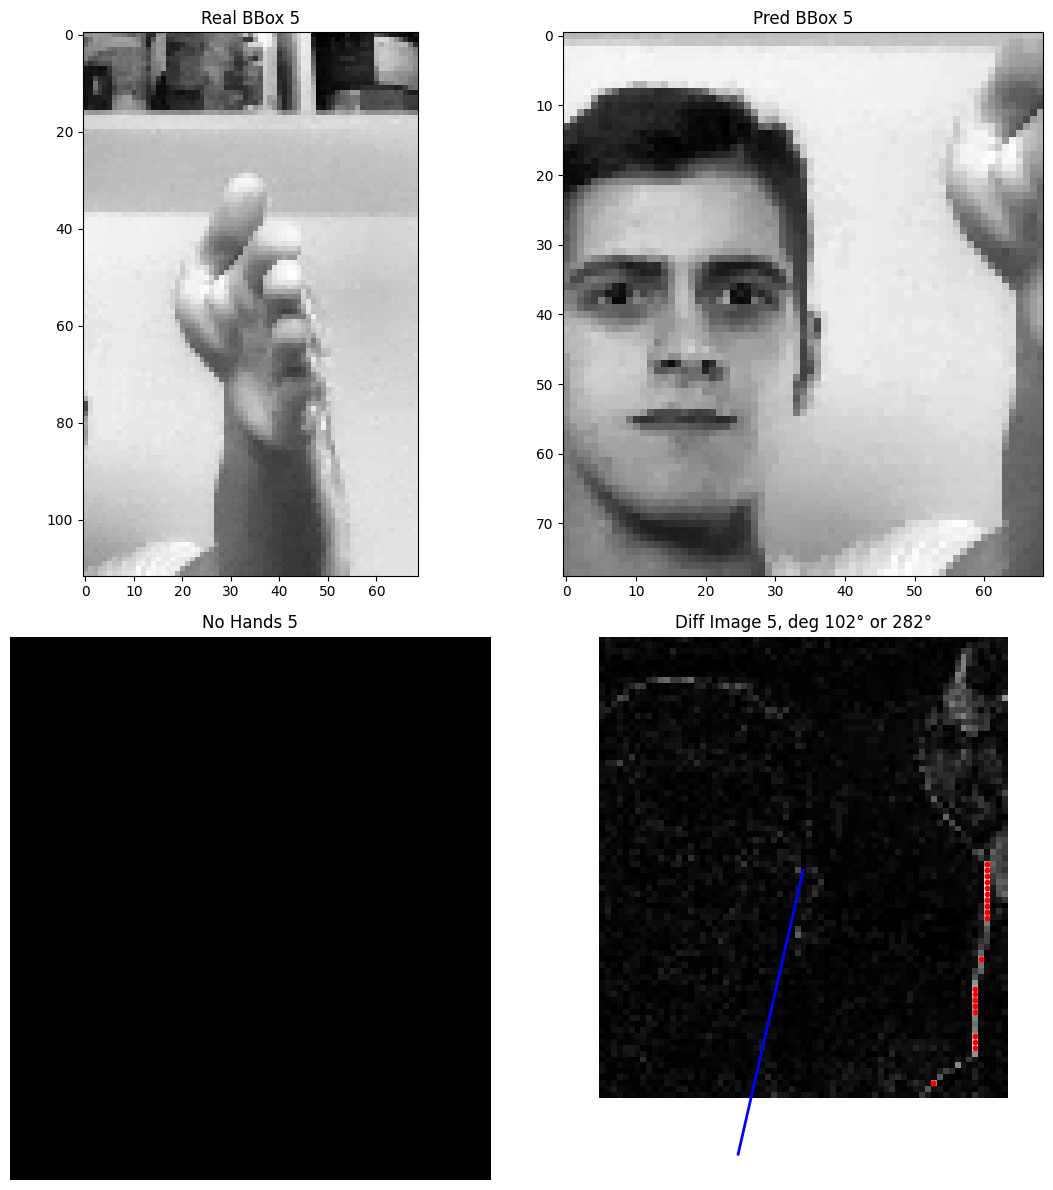

Angle LR: 163.4183887413155° or 343.41838874131554°
No hands detected for image 6!


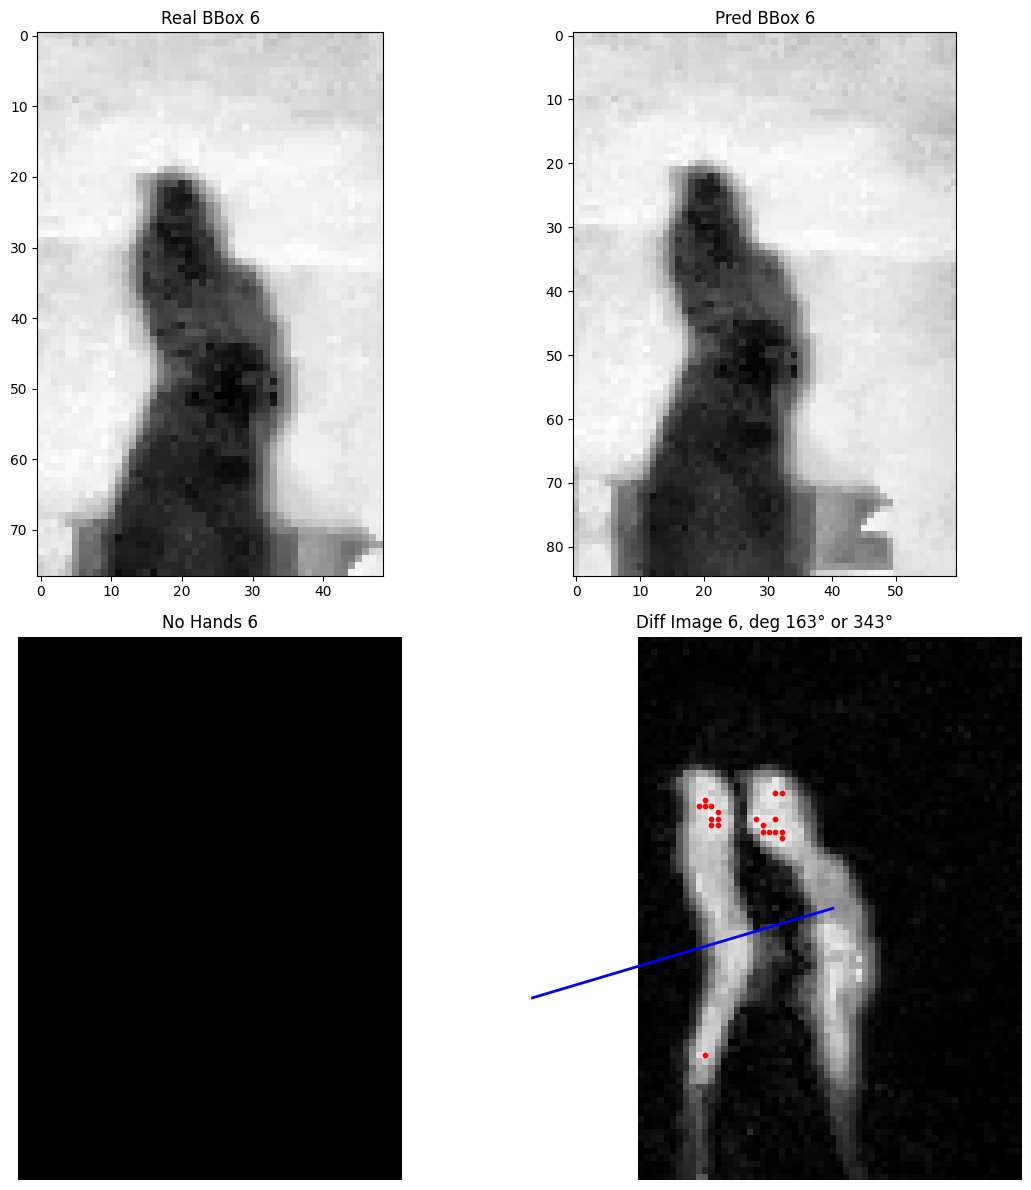

Angle LR: 109.0453830411338° or 289.0453830411338°
No hands detected for image 7!


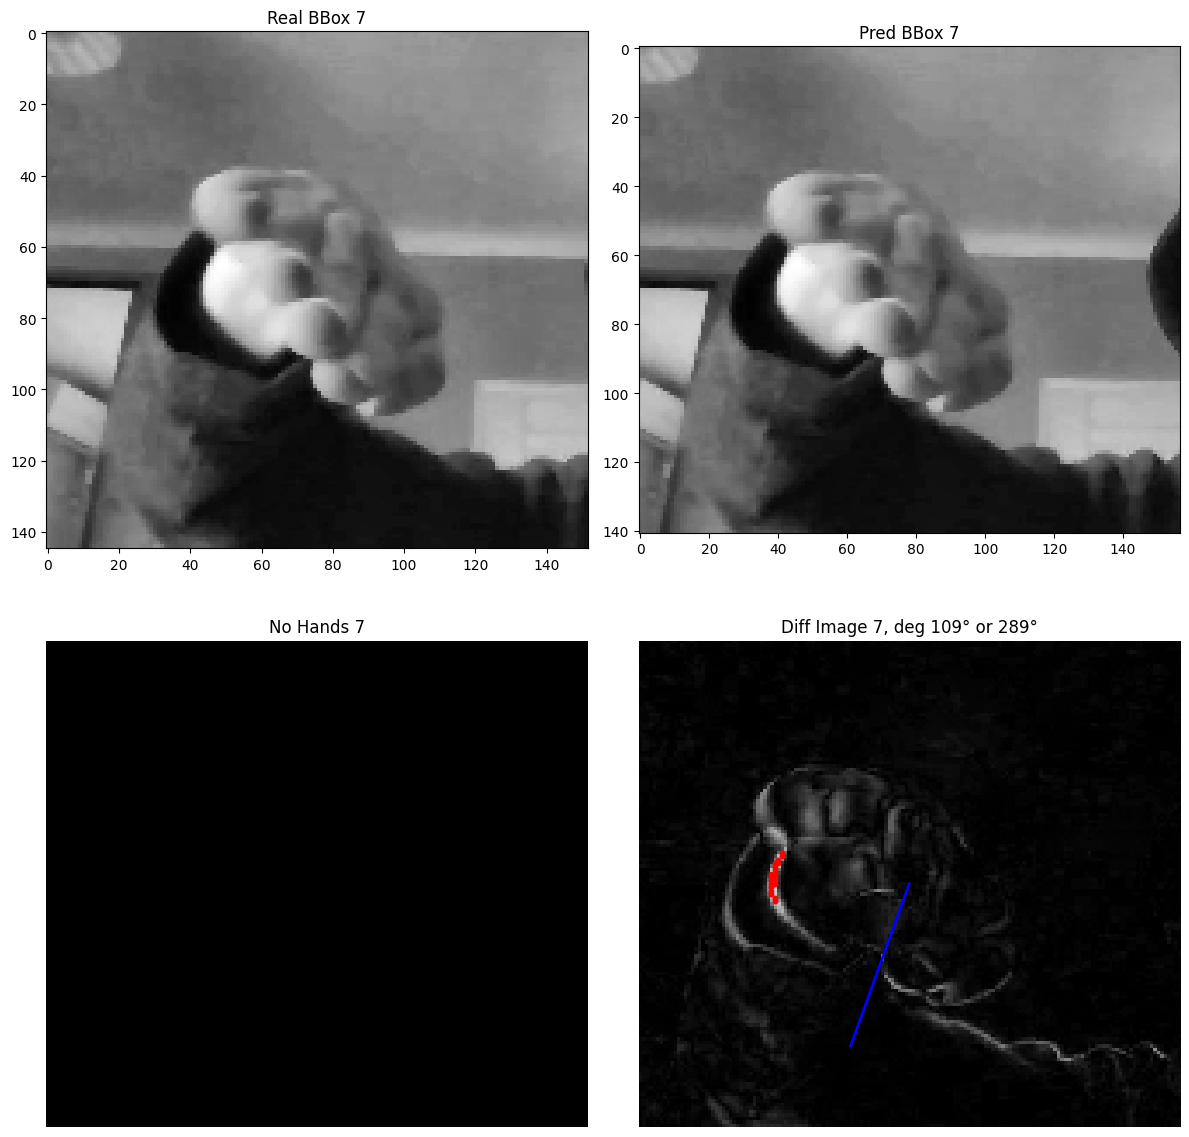

Angle LR: 19.475757805122033° or 199.47575780512204°
Hands detected for image 8!
Angle GOOGLE: 174°


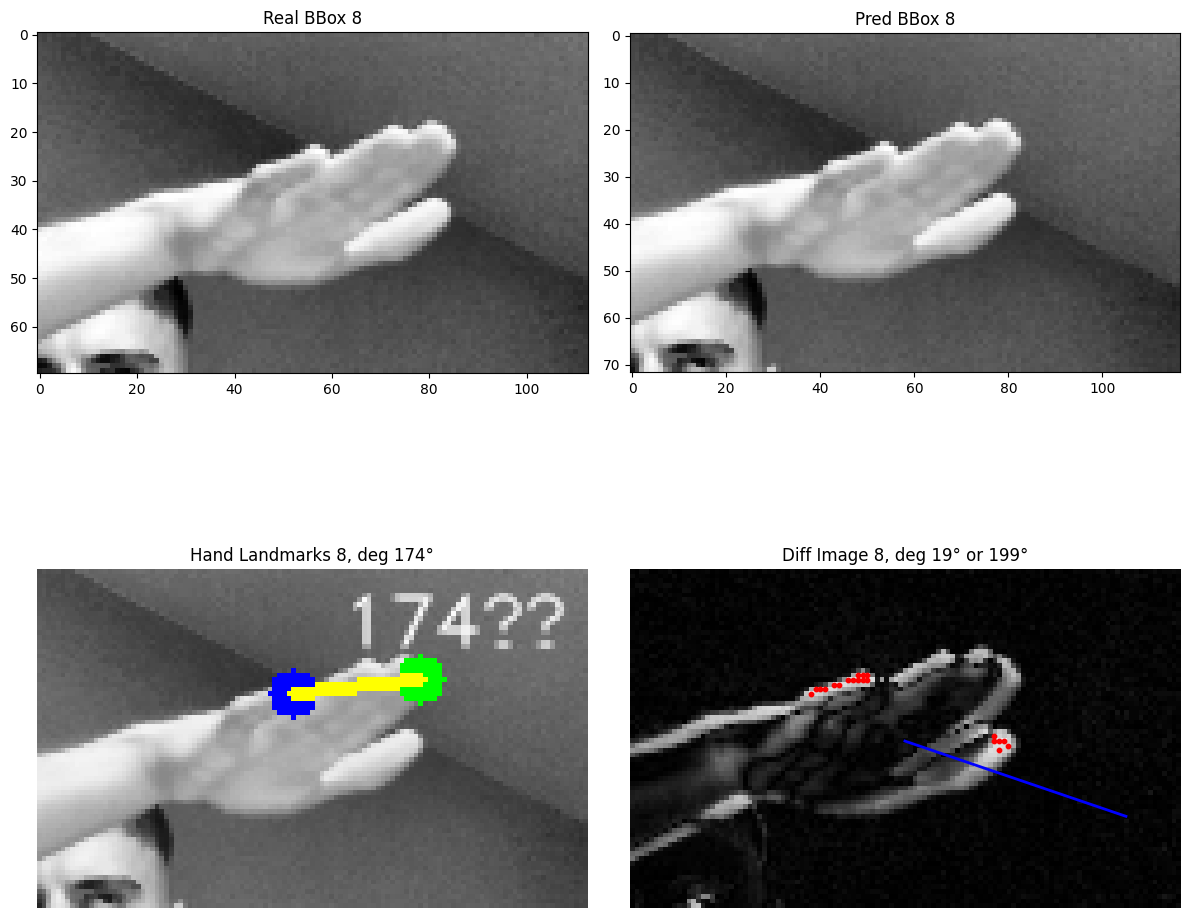

Angle LR: 169.41472482398348° or 349.4147248239835°
No hands detected for image 9!


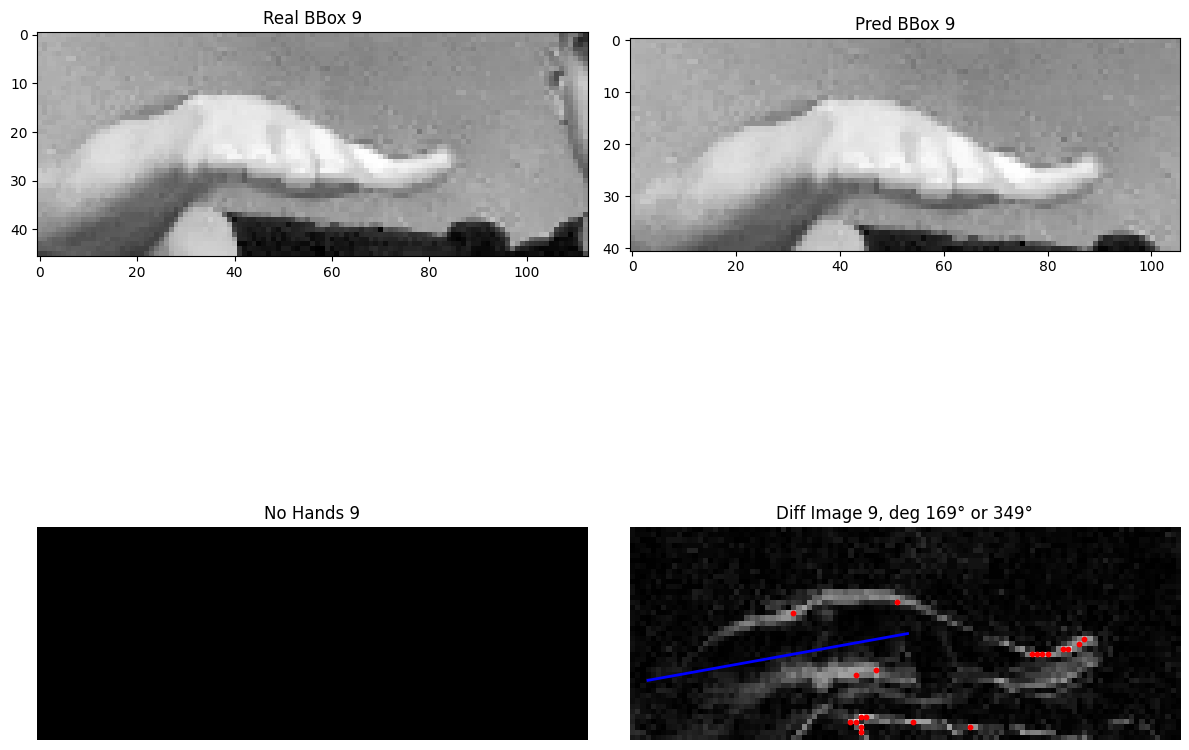

Angle LR: 127.7769831176585° or 307.7769831176585°
No hands detected for image 10!


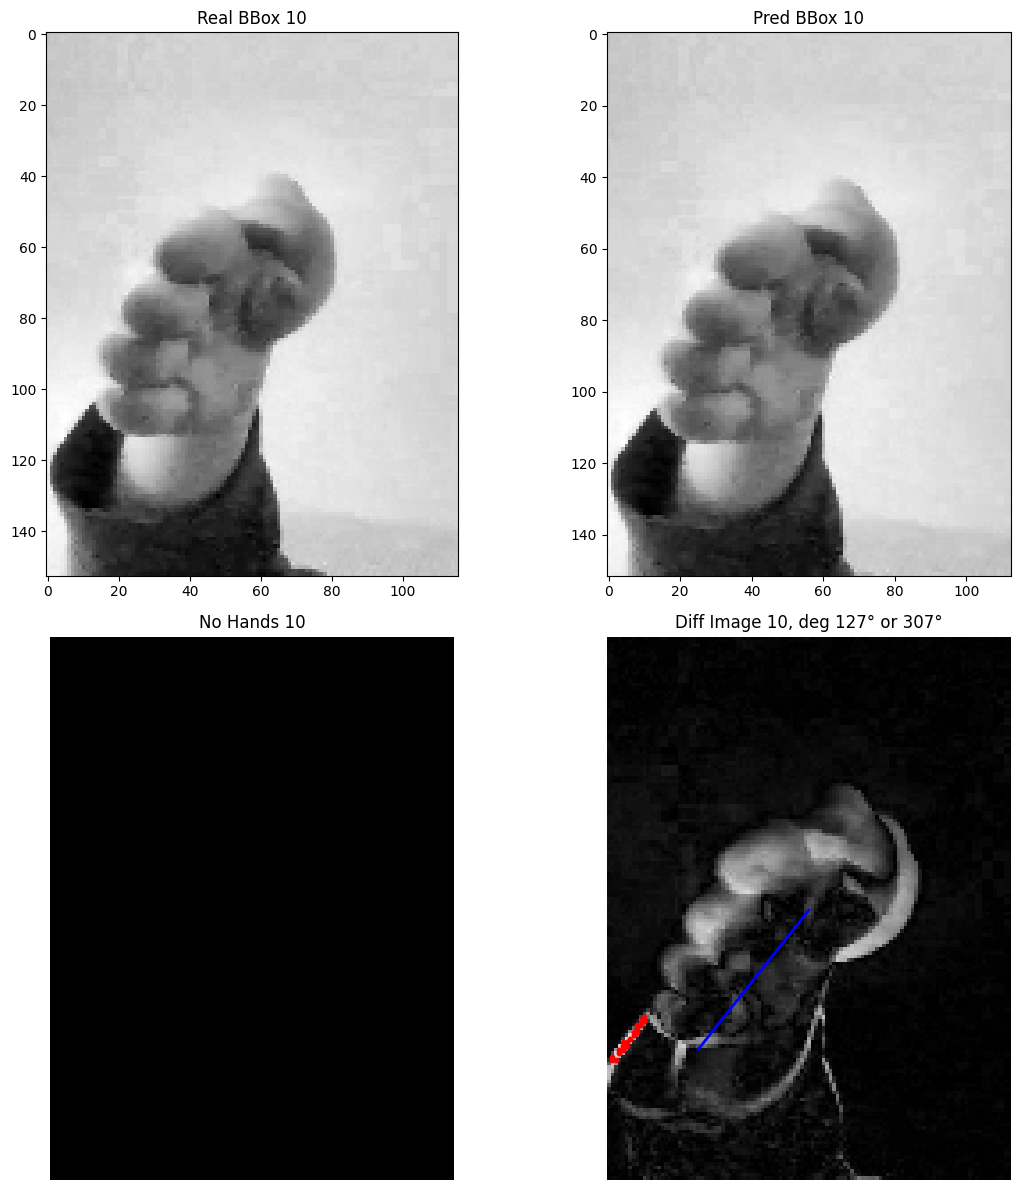

Angle LR: 22.71763832813296° or 202.71763832813295°
No hands detected for image 11!


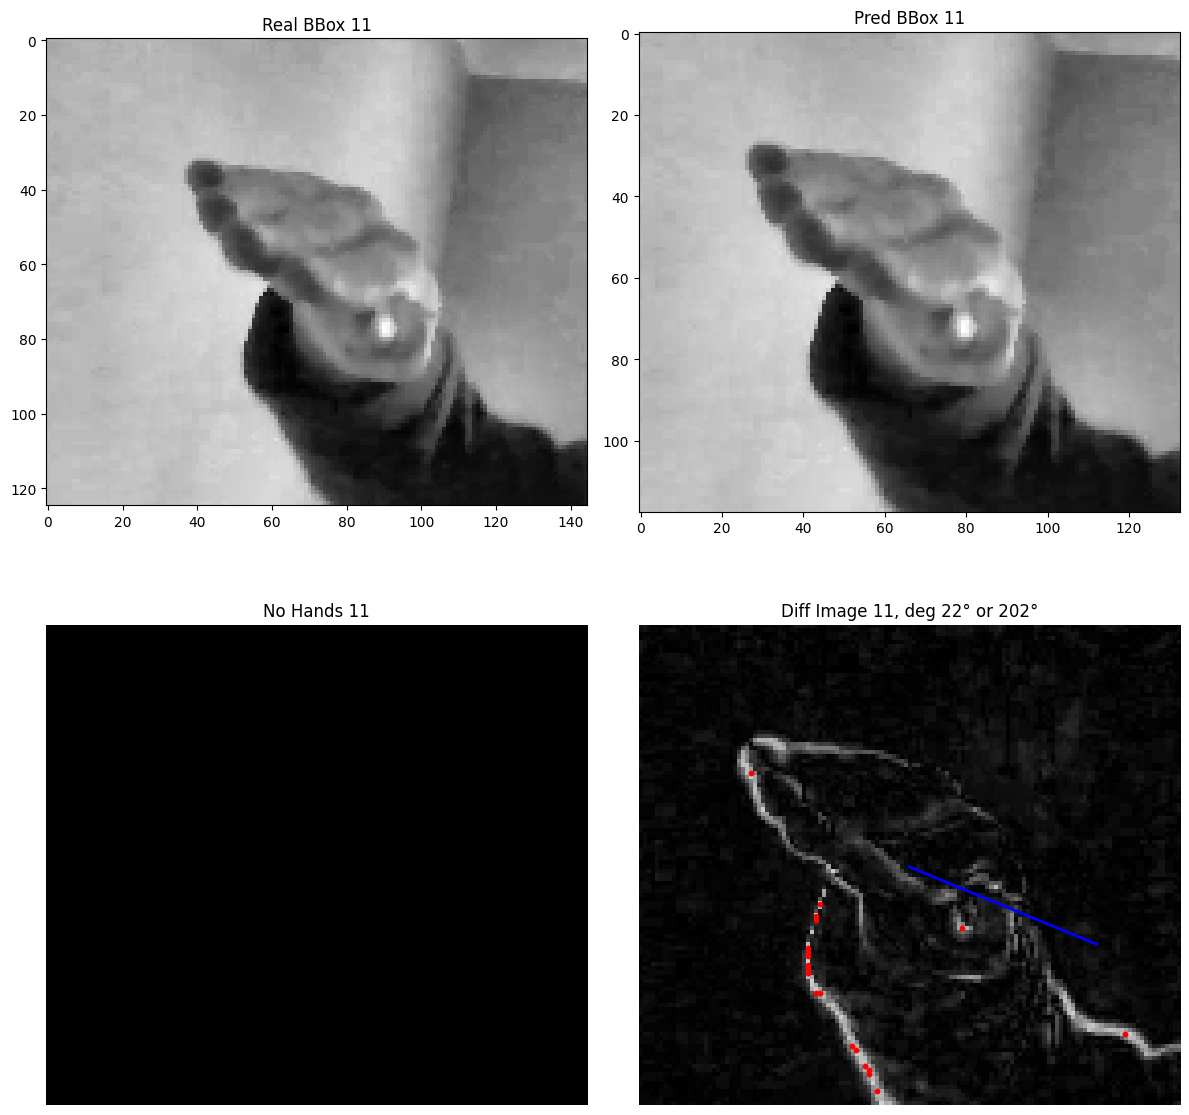

Angle LR: 148.53628380390265° or 328.5362838039026°
No hands detected for image 12!


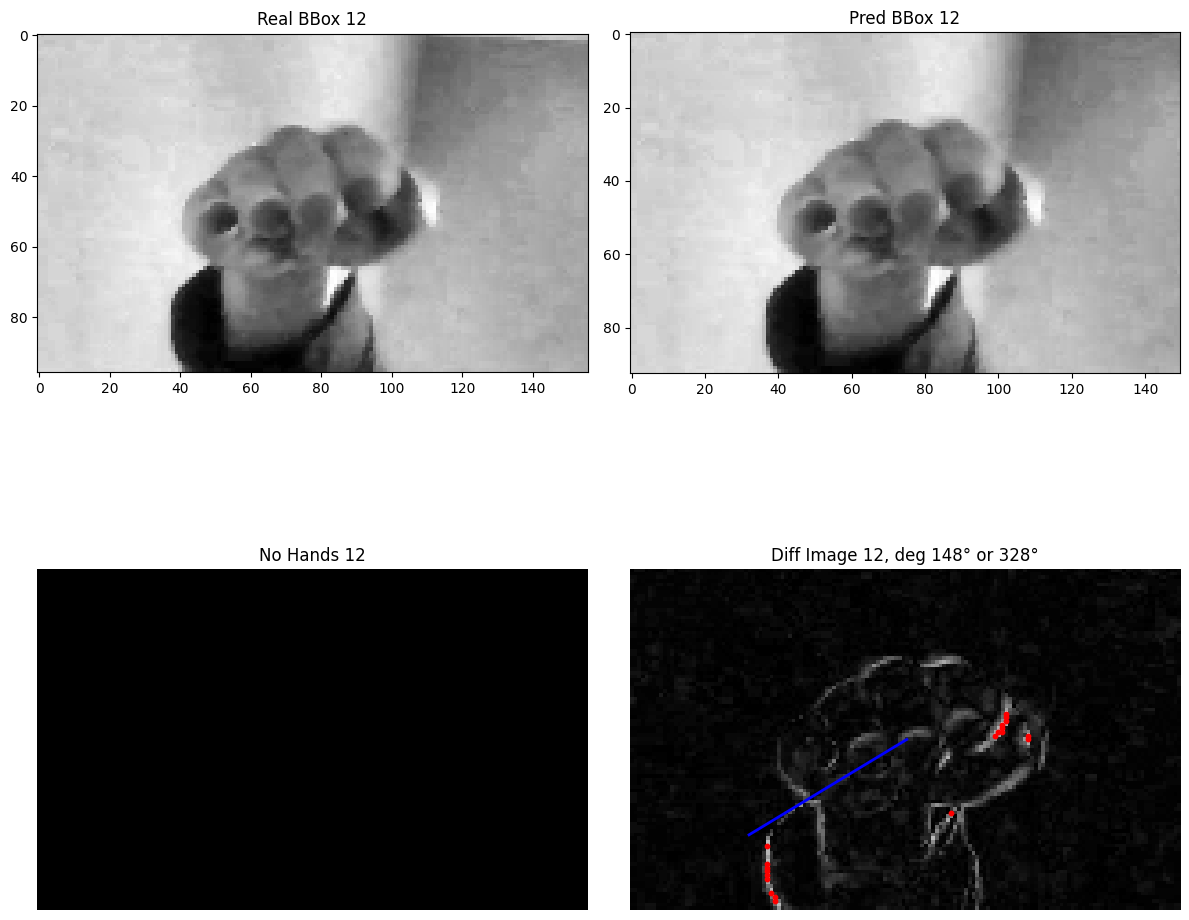

Angle LR: 43.29788436794917° or 223.29788436794917°
No hands detected for image 13!


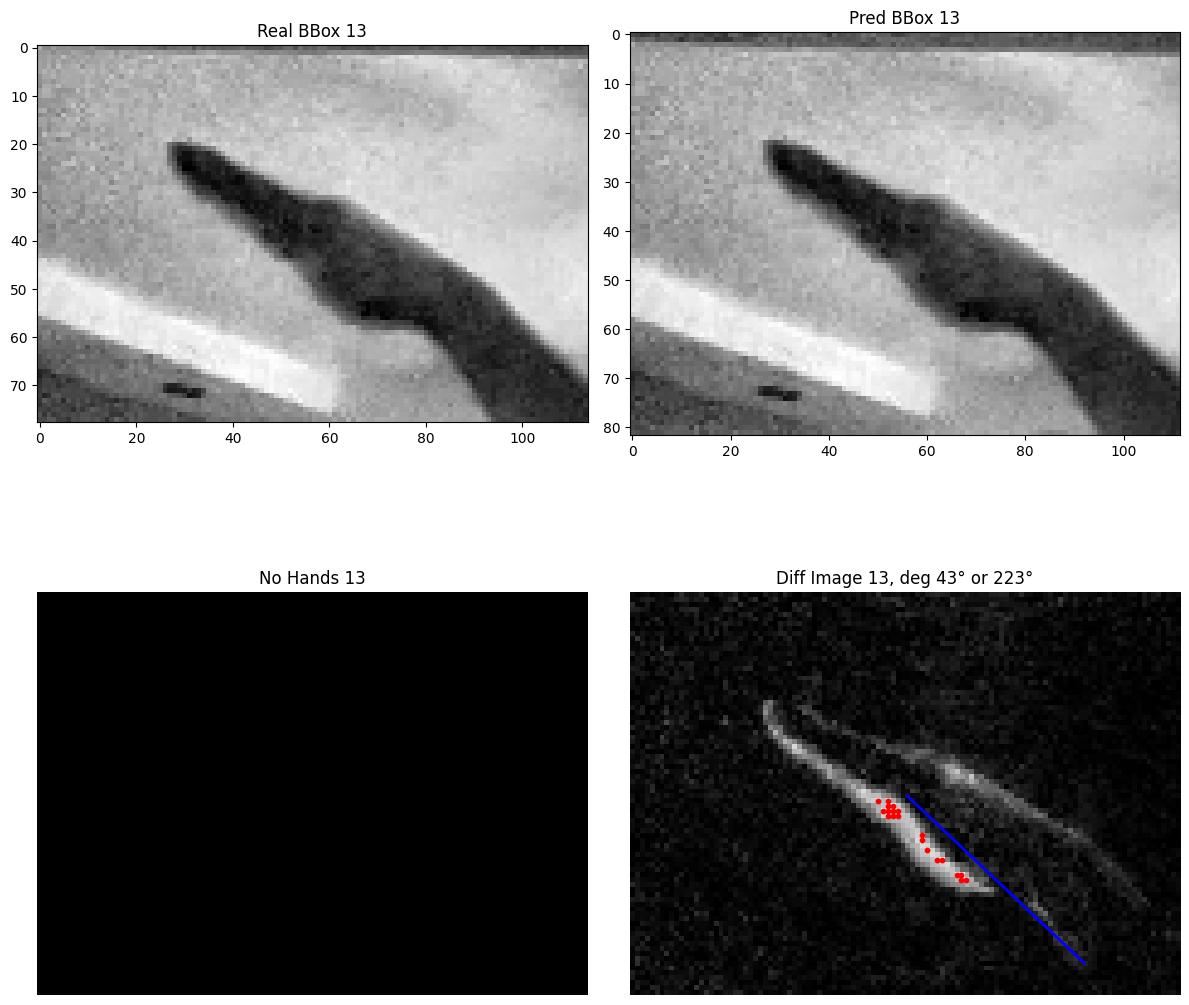

Angle LR: 1.691708661894368° or 181.69170866189438°
Hands detected for image 14!
Angle GOOGLE: 308°


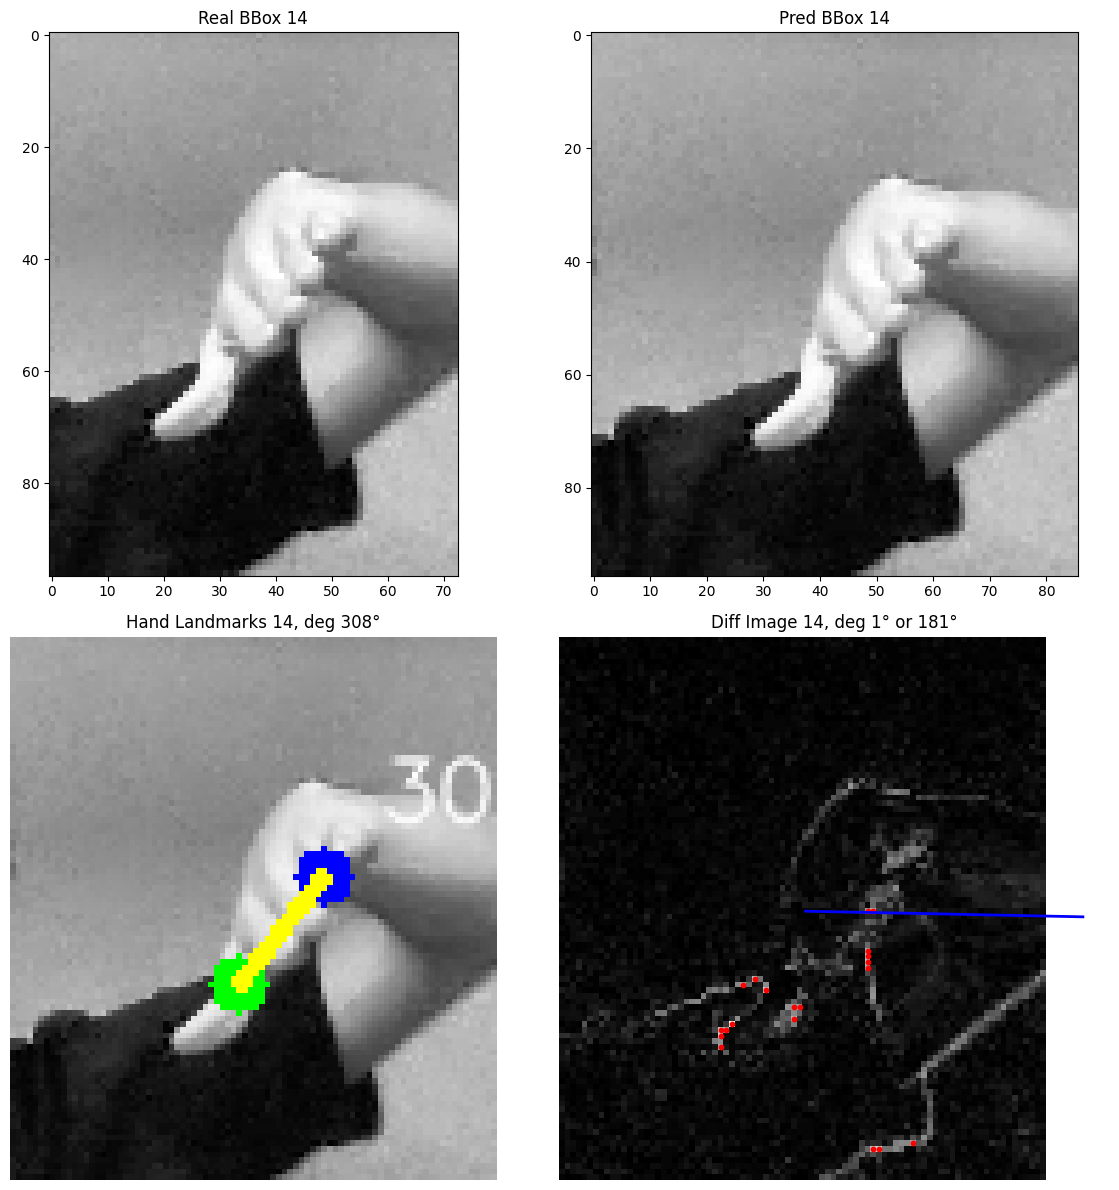

Angle LR: 12.697882521933487° or 192.69788252193348°
No hands detected for image 15!


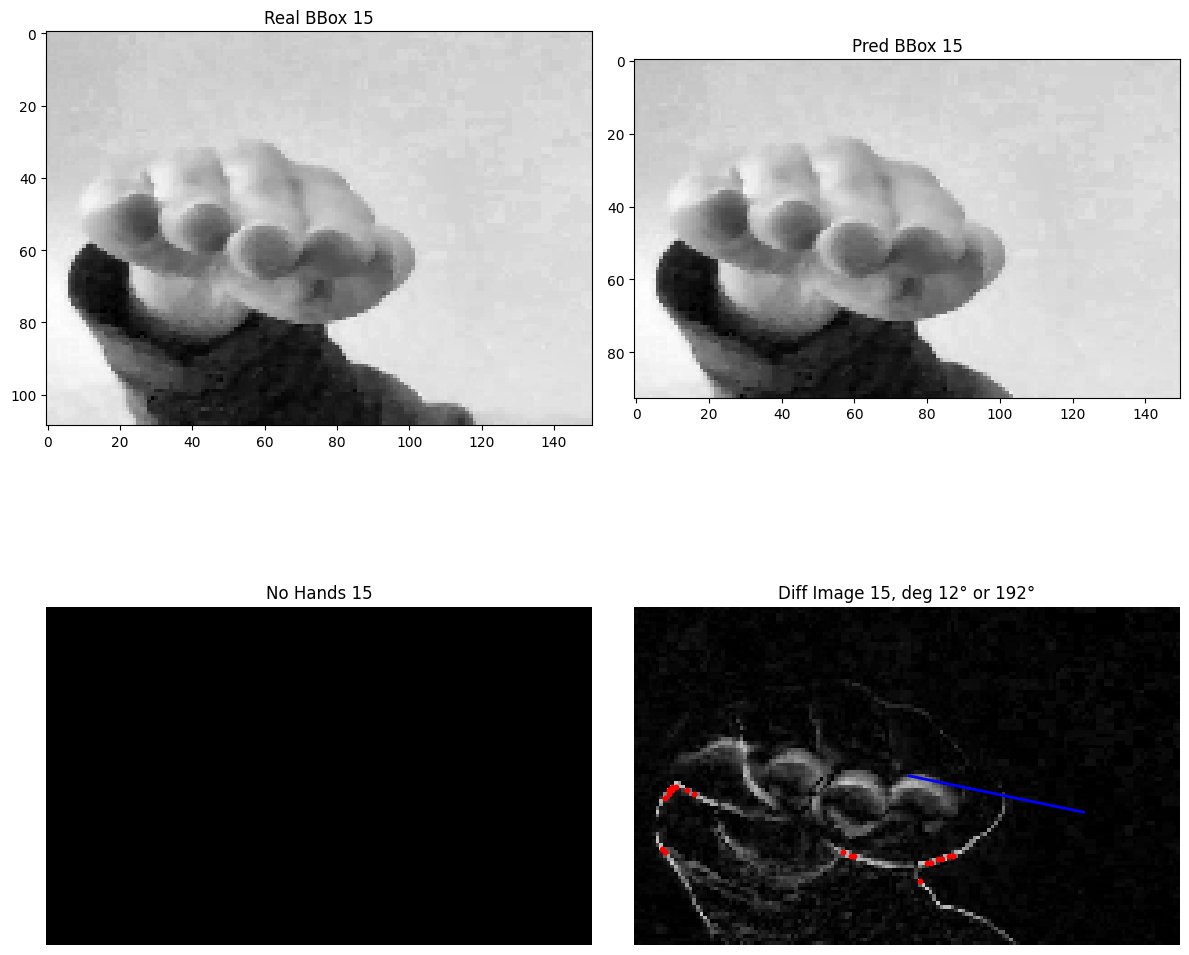

Angle LR: 166.92009513042376° or 346.92009513042376°
No hands detected for image 16!


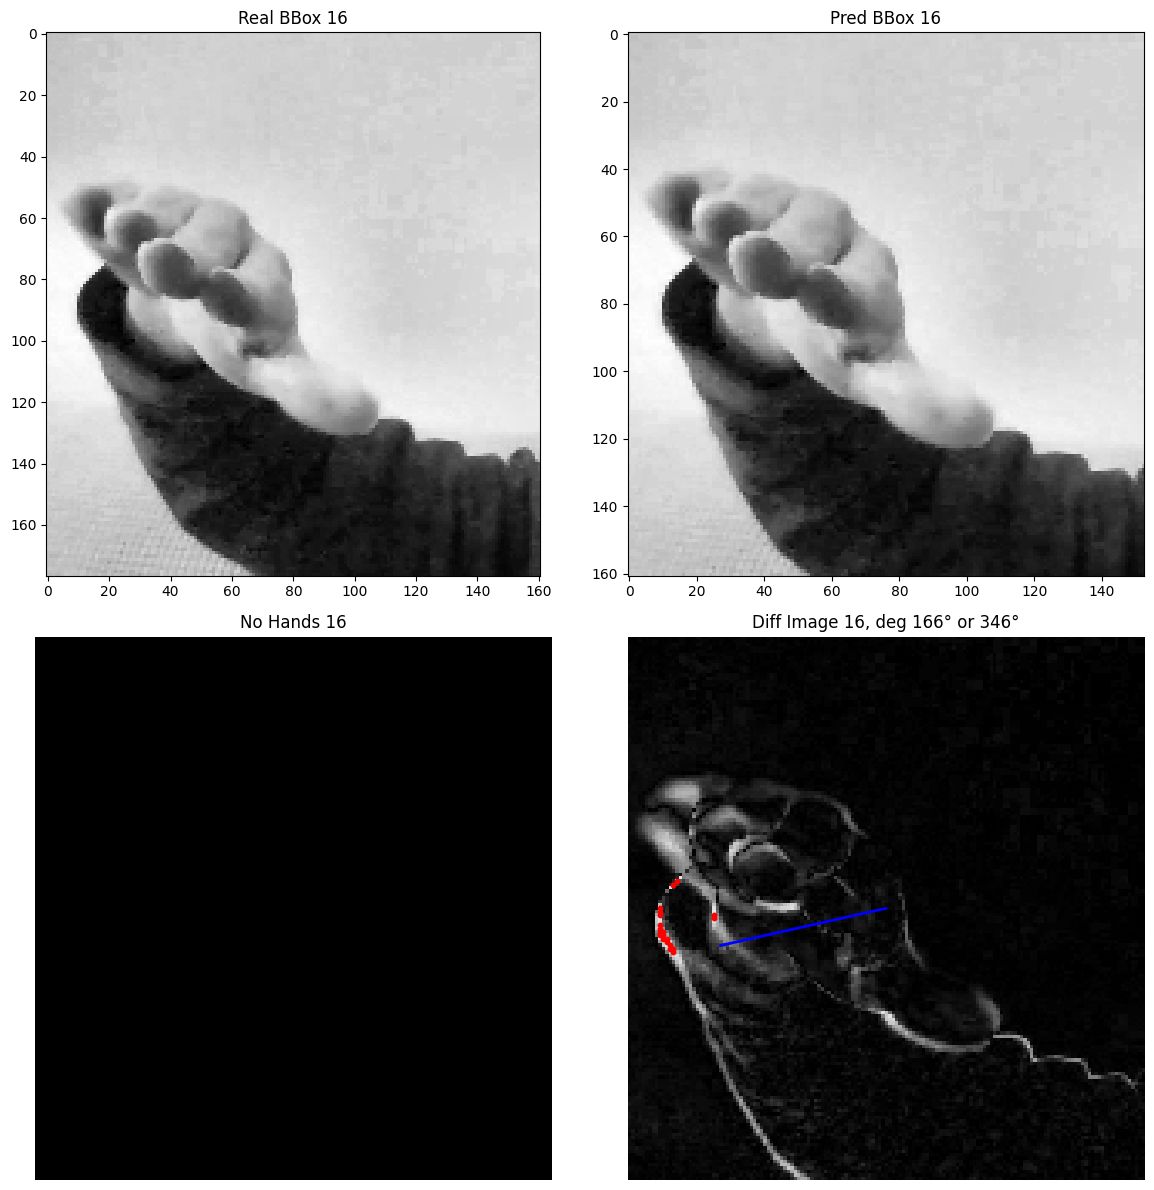

AVG INFERENCE TIME: 0.2033064216375351 s
Google angle activation: 31.25 %
LR angle activation: 68.75 %
Based on 16 samples.


In [95]:
import mediapipe as mp
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.linear_model import LinearRegression

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Initialize MediaPipe Hands object
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.2)

EXPAND_FACTOR = 0.5
avg_time = 0
num_valid_samples = 0

# Filter data where np.argmax(y_test[i][0:4]) == 0
filtered_indices = [i for i in range(len(y_test)) if np.argmax(y_test[i][0:4]) == 0]
num_images = len(filtered_indices)  # Total number of valid images
num_rows = 2  # Two rows for plots
num_cols = 2  # Two columns for plots

K = 20  # Number of top pixels to consider

google_track = []

for idx, i in enumerate(filtered_indices):  # Process all filtered images
    plt.figure(figsize=(12, 6 * num_rows))  # Adjust the figure size to accommodate all the plots
    num_valid_samples += 1

    # Image1 and its prediction
    image1 = X_test[i, ..., 0][np.newaxis, ..., np.newaxis]
    start_time = time.time()
    pred_output = model2.predict(image1, verbose=0)
    end_time = time.time() - start_time
    avg_time += end_time

    # Image2 for the 4th plot
    image2 = X_test[i, ..., 1][np.newaxis, ..., np.newaxis]

    # Prepare images
    image1 = image1 * 255
    image2 = image2 * 255
    img1 = Image.fromarray(image1[0, ..., 0].astype(np.uint8))
    img2 = Image.fromarray(image2[0, ..., 0].astype(np.uint8))

    # Real bbox cropping
    center_x, center_y, width, height = y_test[i][4:]
    left, top = int(center_x - width / 2) - int(width * EXPAND_FACTOR), int(center_y - height / 2) - int(height * EXPAND_FACTOR)
    right, bottom = int(center_x + width / 2) + int(width * EXPAND_FACTOR), int(center_y + height / 2) + int(height * EXPAND_FACTOR)
    real_cropped_image = img1.crop((max(0, left), max(0, top), min(img1.width, right), min(img1.height, bottom)))
    real_cropped_image_np = np.array(real_cropped_image)

    # Predicted bbox cropping for image1
    center_x, center_y, width, height = pred_output[0][4:]
    left, top = int(center_x - width / 2) - int(width * EXPAND_FACTOR), int(center_y - height / 2) - int(height * EXPAND_FACTOR)
    right, bottom = int(center_x + width / 2) + int(width * EXPAND_FACTOR), int(center_y + height / 2) + int(height * EXPAND_FACTOR)
    pred_cropped_image = img1.crop((max(0, left), max(0, top), min(img1.width, right), min(img1.height, bottom)))
    pred_cropped_image_np = np.array(pred_cropped_image)

    # Predicted bbox cropping for image2
    pred_cropped_image2 = img2.crop((max(0, left), max(0, top), min(img2.width, right), min(img2.height, bottom)))
    pred_cropped_image2_np = np.array(pred_cropped_image2)

    #### MOVM CROP ####
    if pred_cropped_image2_np.ndim == 3:
        diff_image = pred_cropped_image2_np[..., 0]  # Assuming grayscale image in the first channel
    else:
        diff_image = pred_cropped_image2_np  # If already 2D, no change

    # Find the top K pixel intensities and their coordinates
    flat_indices = np.argsort(diff_image.ravel())[::-1][:K]  # Indices of top K pixels
    coords = np.column_stack(np.unravel_index(flat_indices, diff_image.shape))  # Convert to 2D coordinates

    # Fit a linear regression model
    x_coords = coords[:, 1].reshape(-1, 1)  # Column vector for x-coordinates
    y_coords = coords[:, 0]  # Array for y-coordinates
    model = LinearRegression()
    model.fit(x_coords, y_coords)

    # Calculate the angle of the fitted line
    slope = model.coef_[0]
    lr_angle_rad = np.arctan(slope)
    lr_angle_deg = np.degrees(lr_angle_rad)

    # Adjust angle to [0, 360) range
    if lr_angle_deg < 0:
        lr_angle_deg += 180
    if lr_angle_deg >= 180:
        lr_angle_deg = 360 - lr_angle_deg

    print(f"Angle LR: {lr_angle_deg}° or {180 + lr_angle_deg}°")

    #############

    # Process Google Hand for image1
    image_np = cv2.cvtColor(pred_cropped_image_np, cv2.COLOR_RGB2BGR)
    results = hands.process(image_np)

    # Plotting each image in a 2x2 grid after printing
    plt.subplot(num_rows, num_cols, 1)  # First plot (Real BBox)
    plt.imshow(real_cropped_image_np, cmap='gray')
    plt.title(f"Real BBox {idx + 1}")
    #plt.axis('off')

    plt.subplot(num_rows, num_cols, 2)  # Second plot (Pred BBox)
    plt.imshow(pred_cropped_image_np, cmap='gray')
    plt.title(f"Pred BBox {idx + 1}")
    #plt.axis('off')

    plt.subplot(num_rows, num_cols, 3)  # Third plot (Hand landmarks or No Hands)
    if results.multi_hand_landmarks:
        google_track.append(1)
        print(f"Hands detected for image {idx + 1}!")
        for hand_landmarks in results.multi_hand_landmarks:
            landmark_8 = hand_landmarks.landmark[8]
            landmark_20 = hand_landmarks.landmark[20]

            h, w, _ = image_np.shape
            point_8 = (int(landmark_8.x * w), int(landmark_8.y * h))
            point_20 = (int(landmark_20.x * w), int(landmark_20.y * h))

            dx = point_20[0] - point_8[0]
            dy = point_20[1] - point_8[1]
            angle_rad = math.atan2(dy, dx)
            angle_deg = math.degrees(angle_rad)
            if angle_deg < 0:
                angle_deg += 360
            goog_angle_deg = int(round(angle_deg))

            print(f"Angle GOOGLE: {goog_angle_deg}°")

            cv2.putText(
                image_np,
                f"{goog_angle_deg}°",
                (point_20[0] + 10, point_20[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 255, 255),
                1,
                cv2.LINE_AA
            )
            cv2.circle(image_np, point_8, 5, (0, 255, 0), -1)
            cv2.circle(image_np, point_20, 5, (255, 0, 0), -1)
            cv2.line(image_np, point_8, point_20, (0, 255, 255), 2)

        plt.subplot(num_rows, num_cols, 3)  # Bottom-left for hand landmarks
        plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
        plt.title(f"Hand Landmarks {idx + 1}, deg {goog_angle_deg}°")
        plt.axis('off')
    else:
        google_track.append(0)
        print(f"No hands detected for image {idx + 1}!")
        plt.subplot(num_rows, num_cols, 3)
        plt.imshow(np.zeros_like(image_np), cmap='gray')
        plt.title(f"No Hands {idx + 1}")
        plt.axis('off')

    plt.subplot(num_rows, num_cols, 4)  # Fourth plot (Difference Image with Top K pixels)
    plt.imshow(pred_cropped_image2_np, cmap='gray')
    plt.title(f"Diff Image {idx + 1}, deg {int(lr_angle_deg)}° or {180 + int(lr_angle_deg)}°")

    # Draw line based on lr_angle_deg
    # Get image center coordinates
    center_y, center_x = diff_image.shape[0] // 2, diff_image.shape[1] // 2
    line_length = 50  # Length of the line to draw

    # Calculate end point of the line using angle
    end_x = int(center_x + line_length * np.cos(np.radians(lr_angle_deg)))
    end_y = int(center_y + line_length * np.sin(np.radians(lr_angle_deg)))

    # Draw the line
    plt.plot([center_x, end_x], [center_y, end_y], color='blue', linewidth=2)

    # Mark top K pixels with red dots
    for coord in coords:
        plt.scatter(coord[1], coord[0], c='red', s=10)  # Mark top K pixels with red dots

    plt.axis('off')

    # Display all plots
    plt.tight_layout()
    plt.show()

# Print the average inference time
if num_valid_samples > 0:
    print("AVG INFERENCE TIME:", avg_time / num_valid_samples, "s")
else:
    print("No valid samples found!")


srv = np.mean(google_track)
print("Google angle activation:", srv *100, "%")
print("LR angle activation:", (1 - srv)*100, "%")
print("Based on", len(google_track), "samples.")


Angle LR: 145.7902009975142° or 325.7902009975142°
No hands detected for image 1!


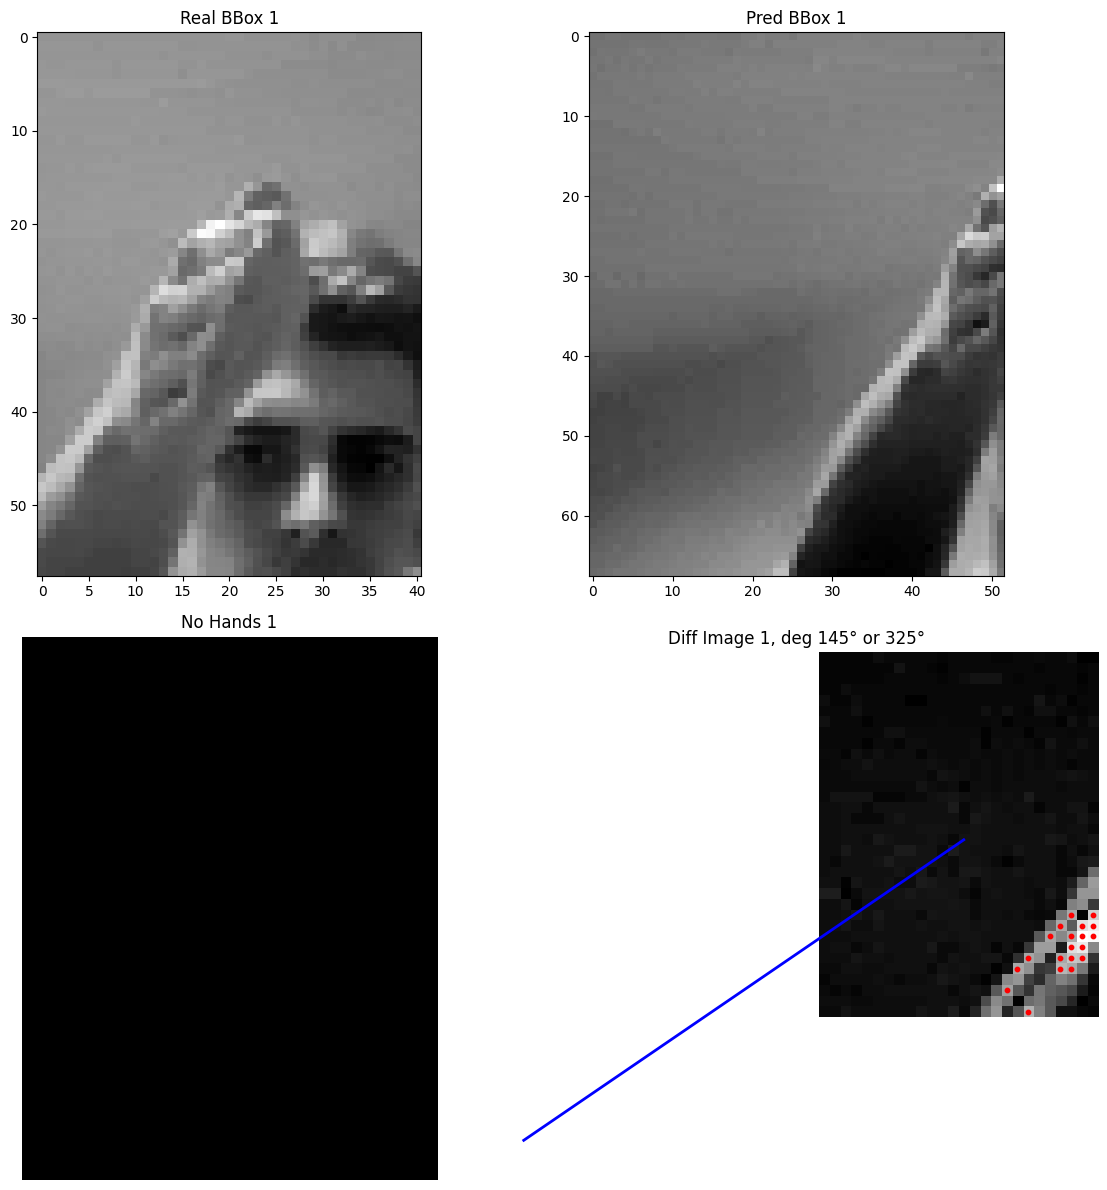

Angle LR: 8.326871350991881° or 188.3268713509919°
Hands detected for image 2!
Angle GOOGLE: 74°


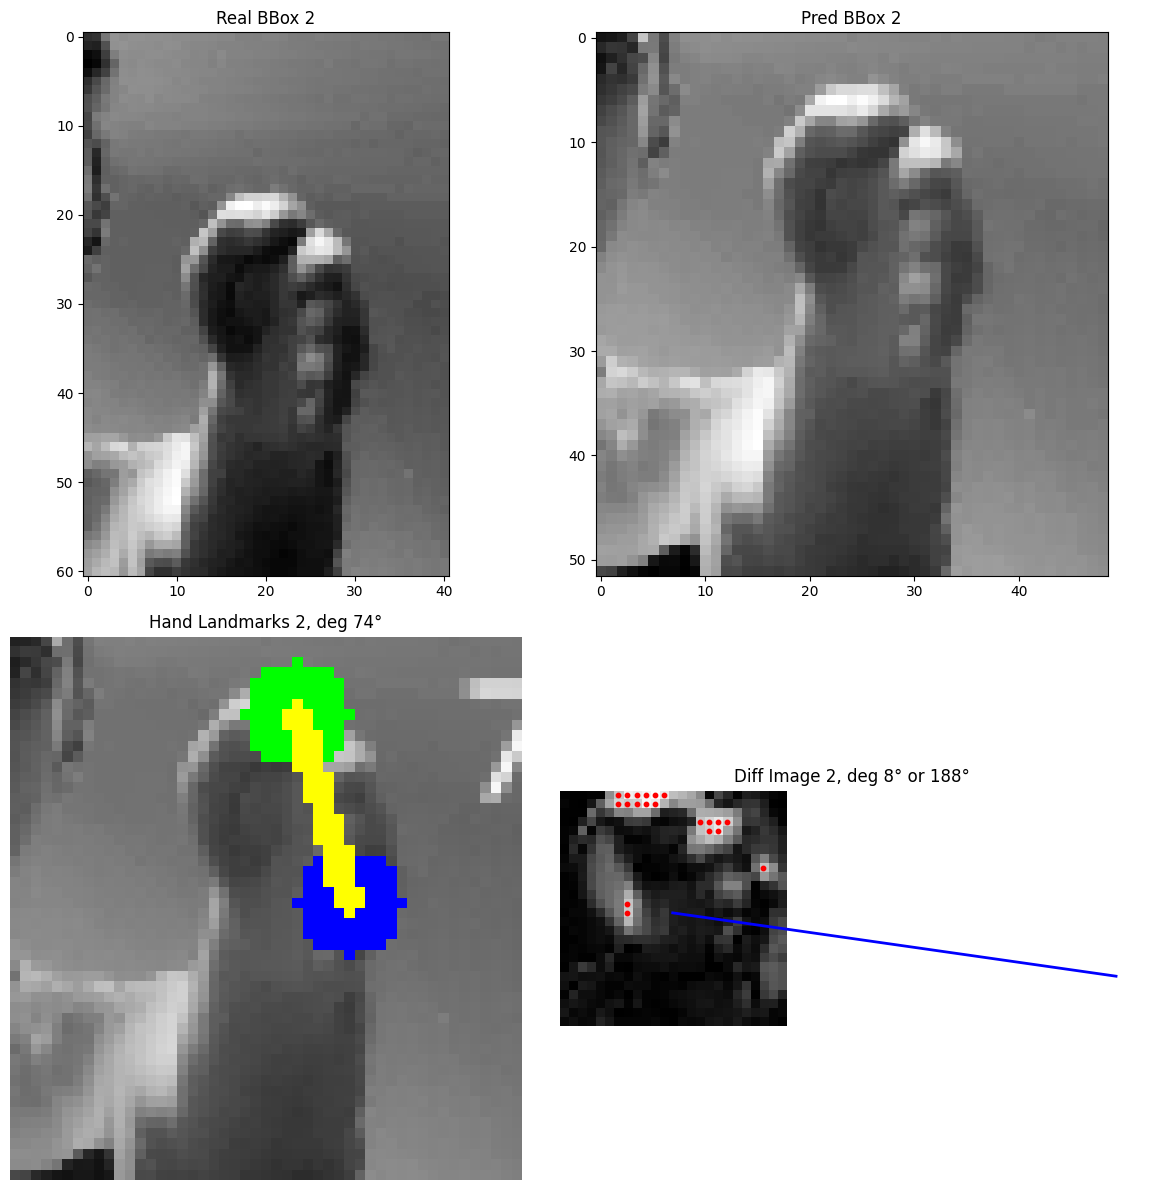

Angle LR: 178.71787794477143° or 358.71787794477143°
Hands detected for image 3!
Angle GOOGLE: 332°


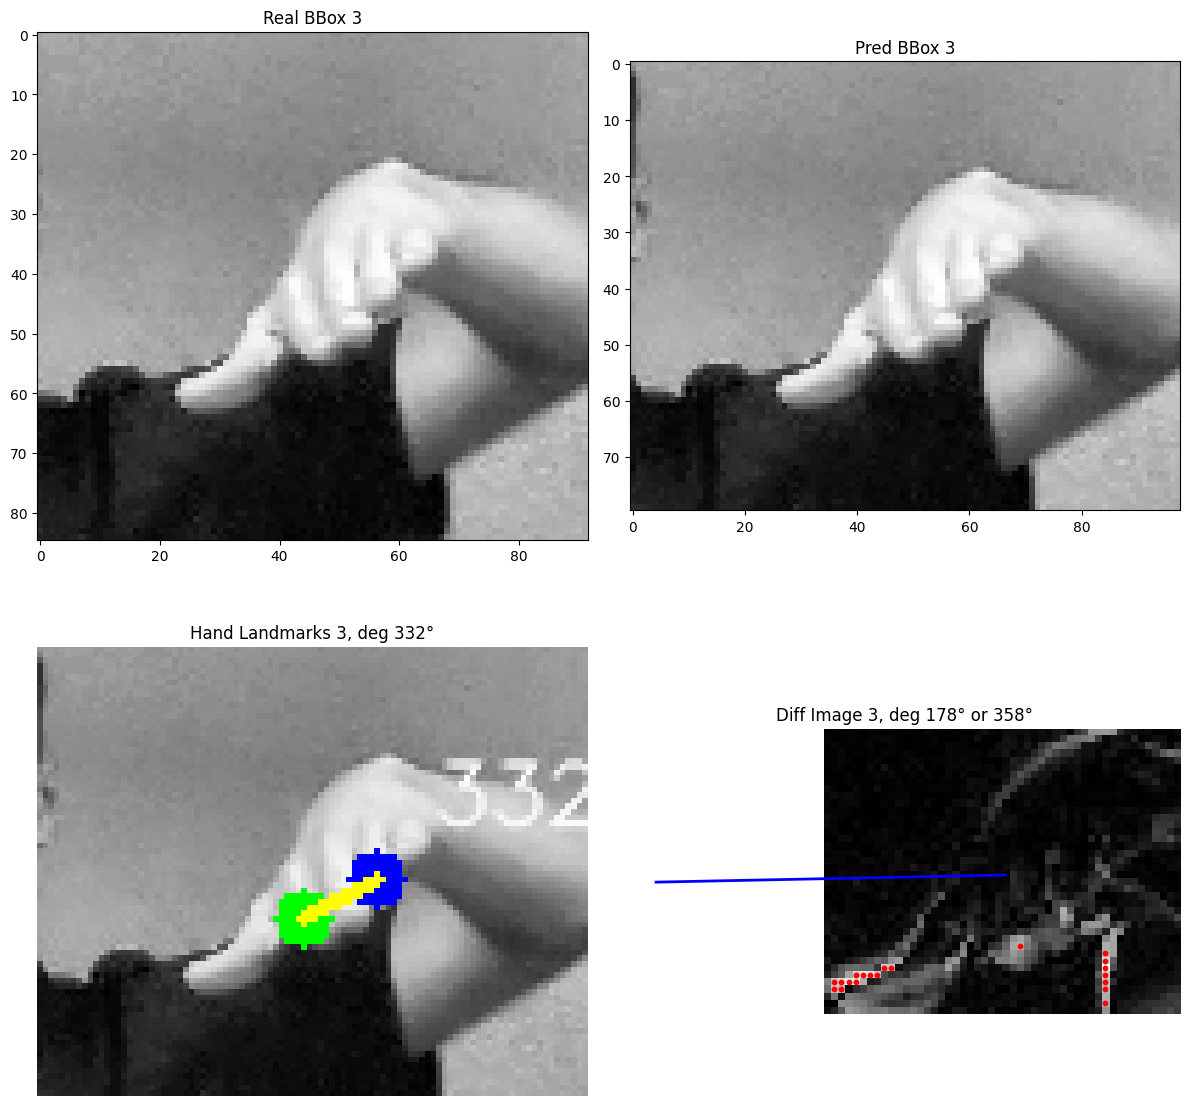

Angle LR: 1.2821220552285637° or 181.28212205522857°
Hands detected for image 4!
Angle GOOGLE: 219°


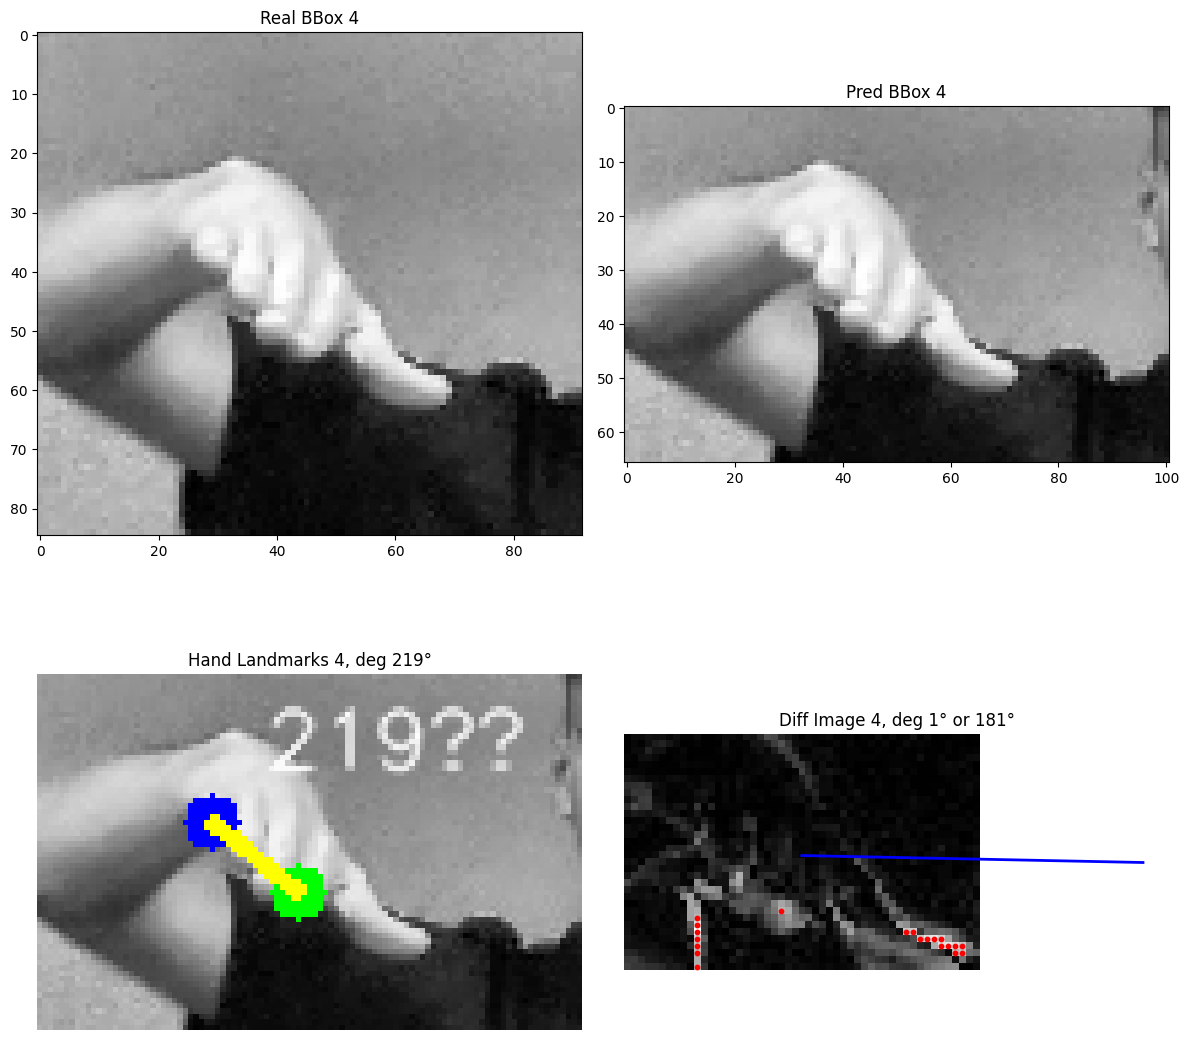

Angle LR: 172.49390585292656° or 352.49390585292656°
No hands detected for image 5!


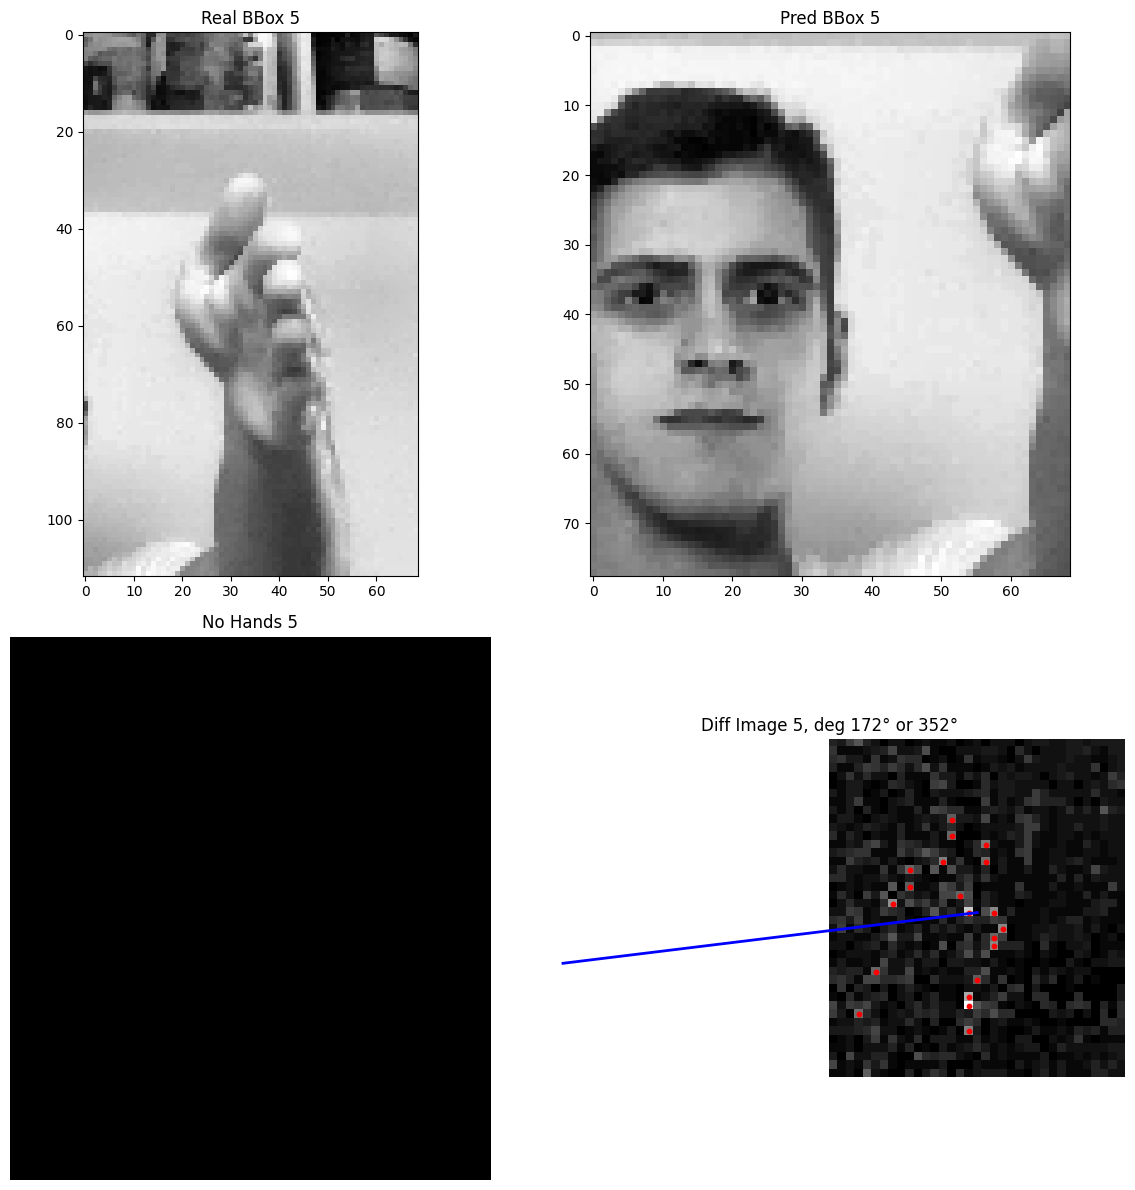

Angle LR: 57.492806871615656° or 237.49280687161564°
No hands detected for image 6!


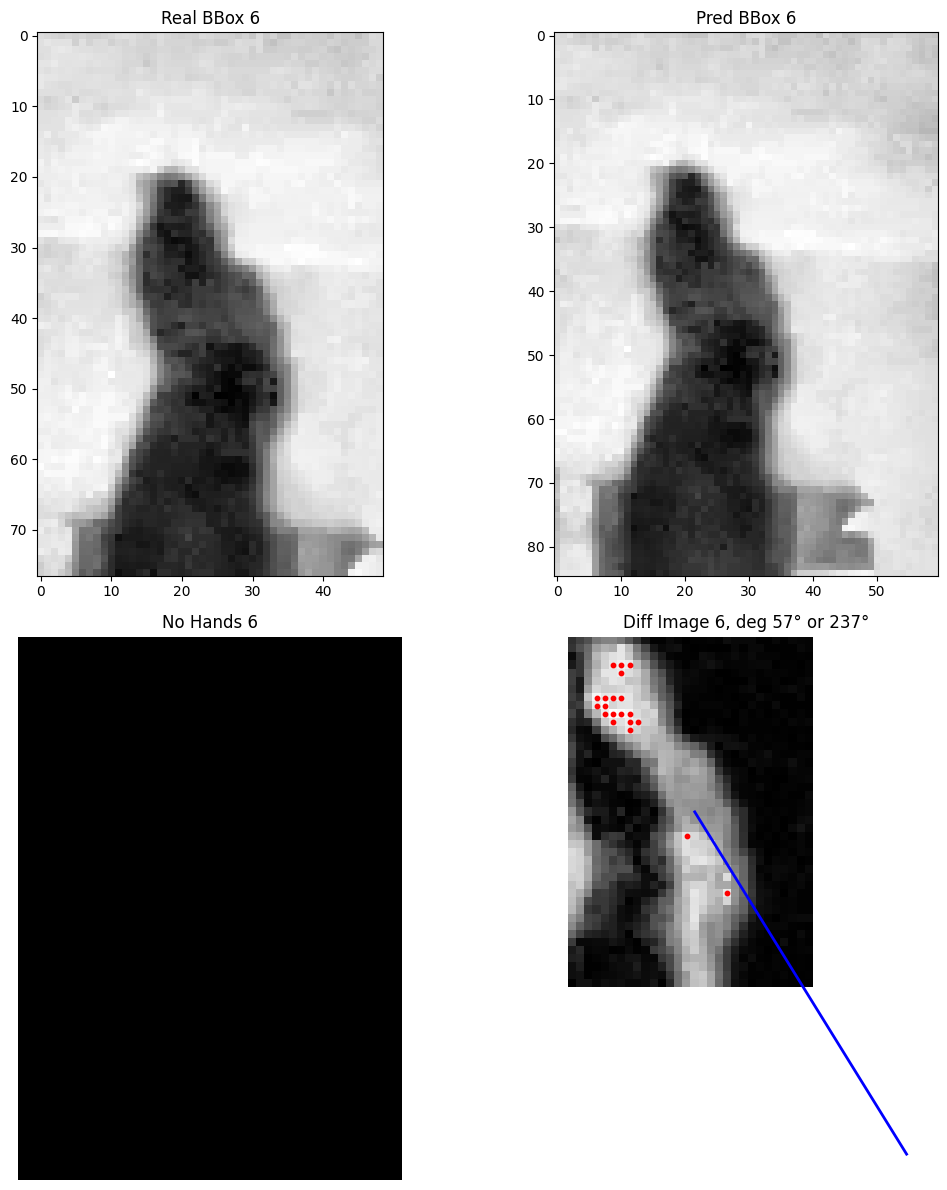

Angle LR: 107.24145939893998° or 287.24145939894°
No hands detected for image 7!


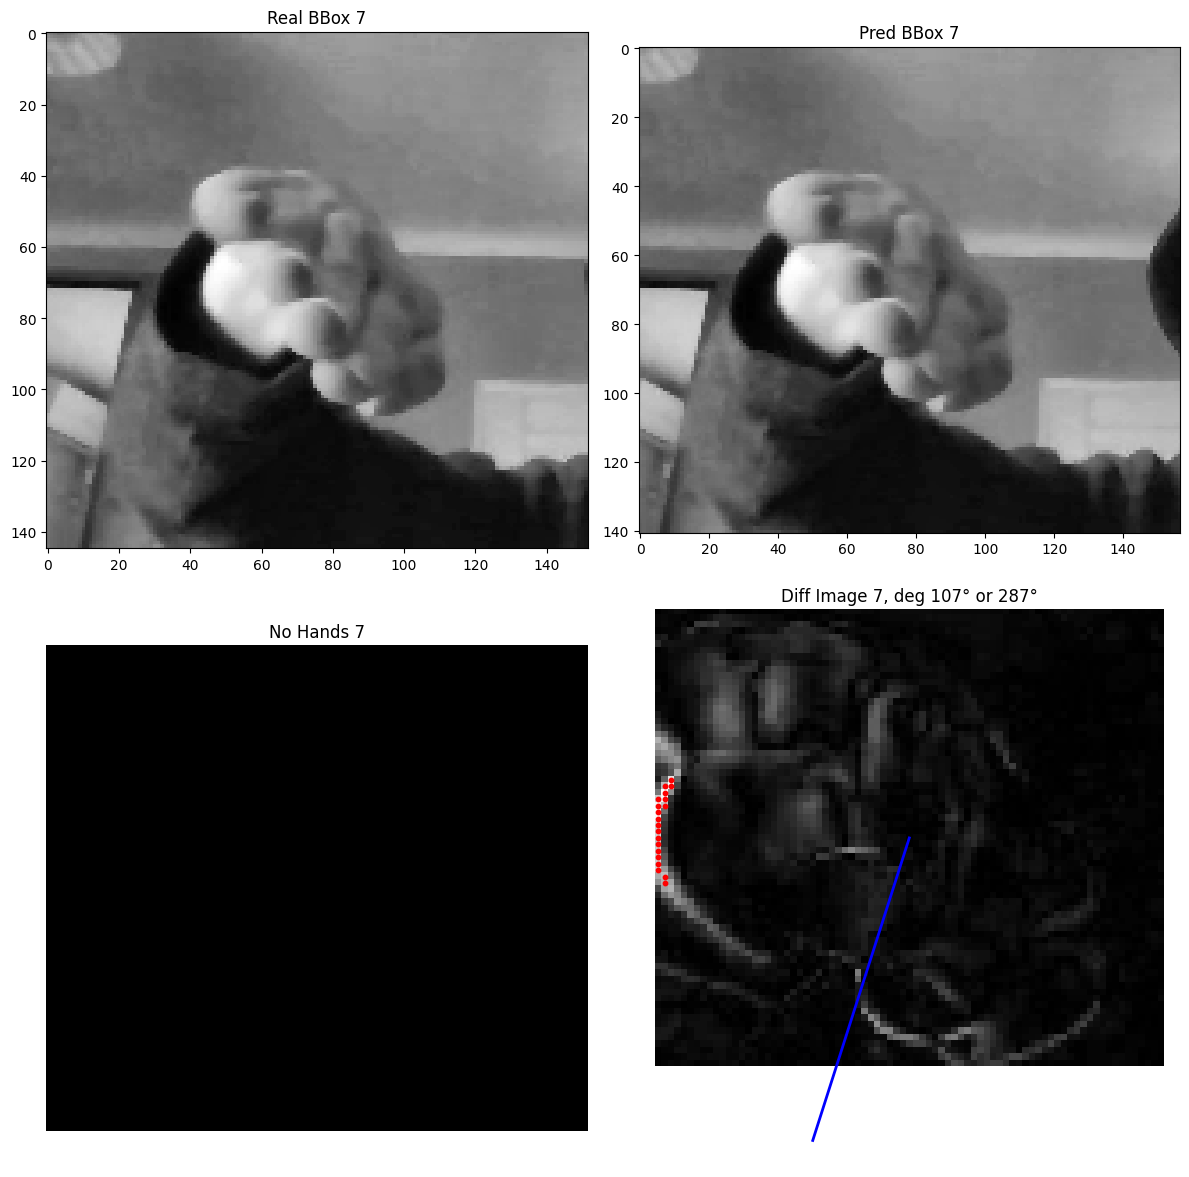

Angle LR: 19.475757805122036° or 199.47575780512204°
Hands detected for image 8!
Angle GOOGLE: 174°


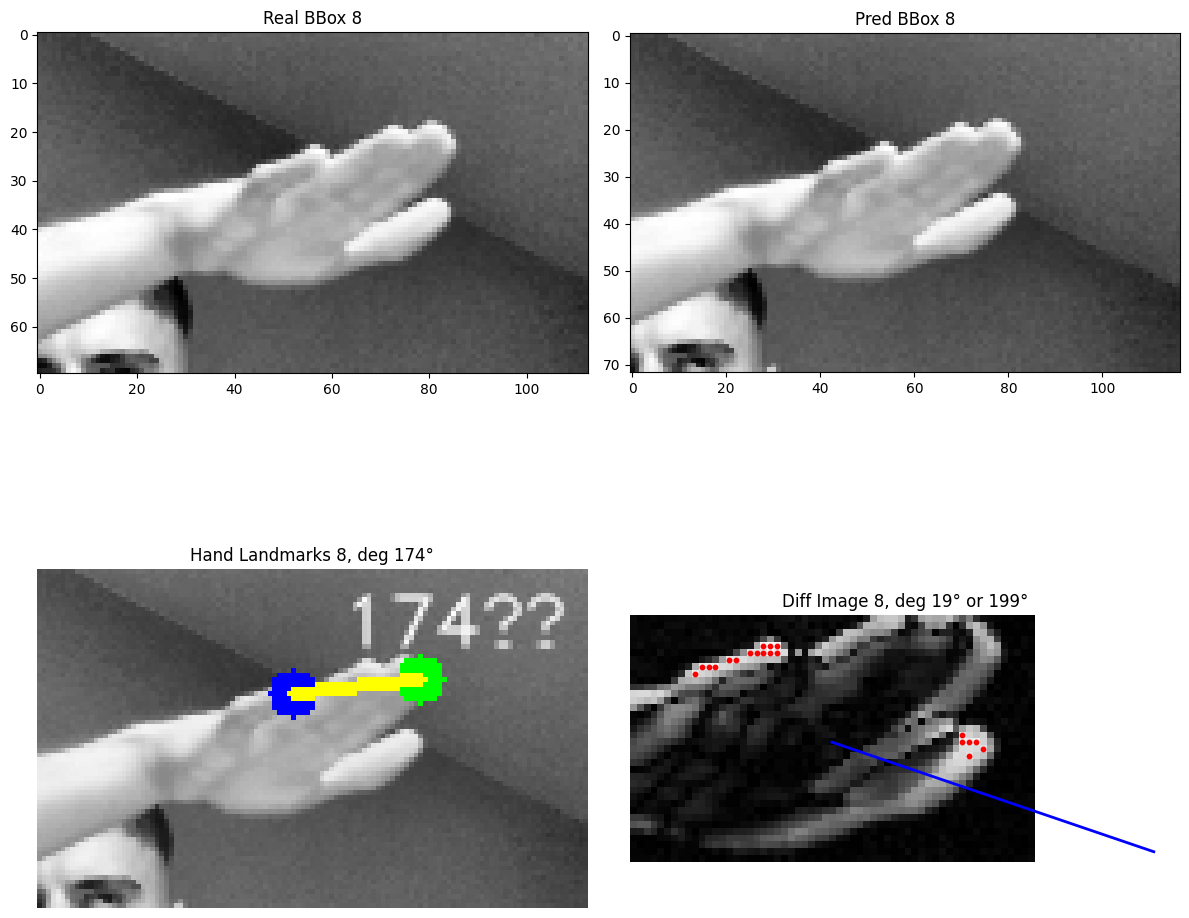

Angle LR: 3.309592521615834° or 183.30959252161583°
No hands detected for image 9!


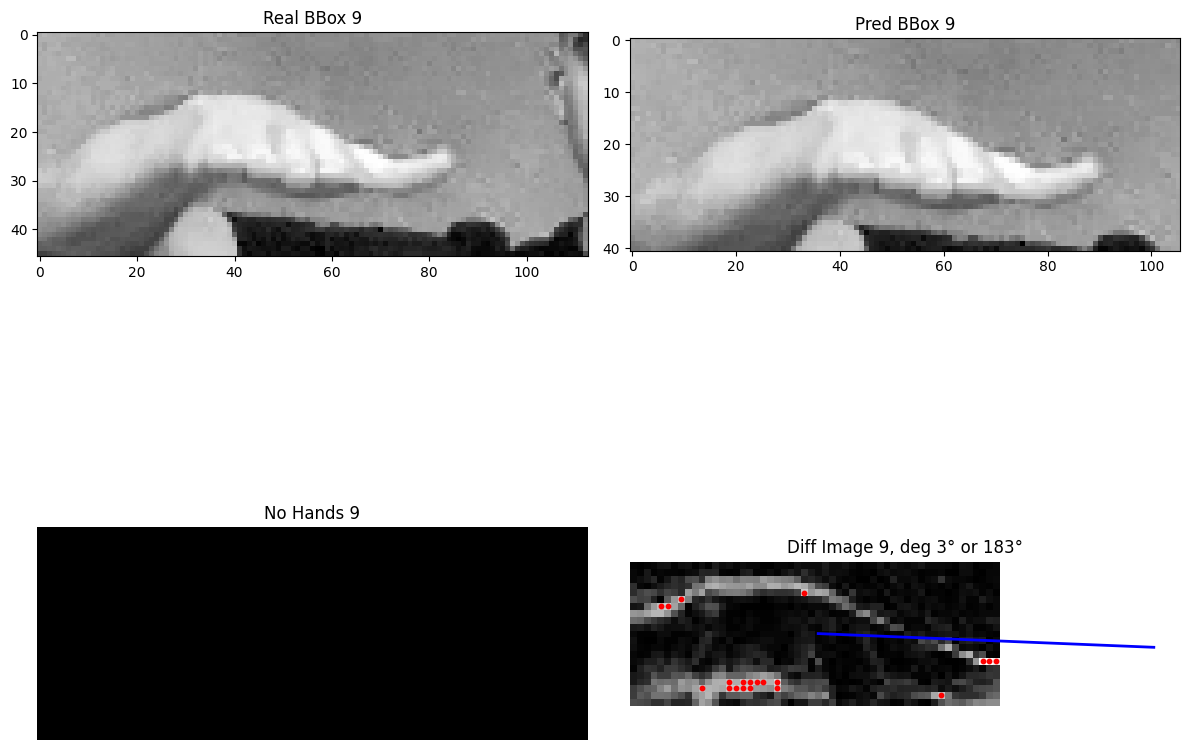

Angle LR: 15.168291013012205° or 195.1682910130122°
No hands detected for image 10!


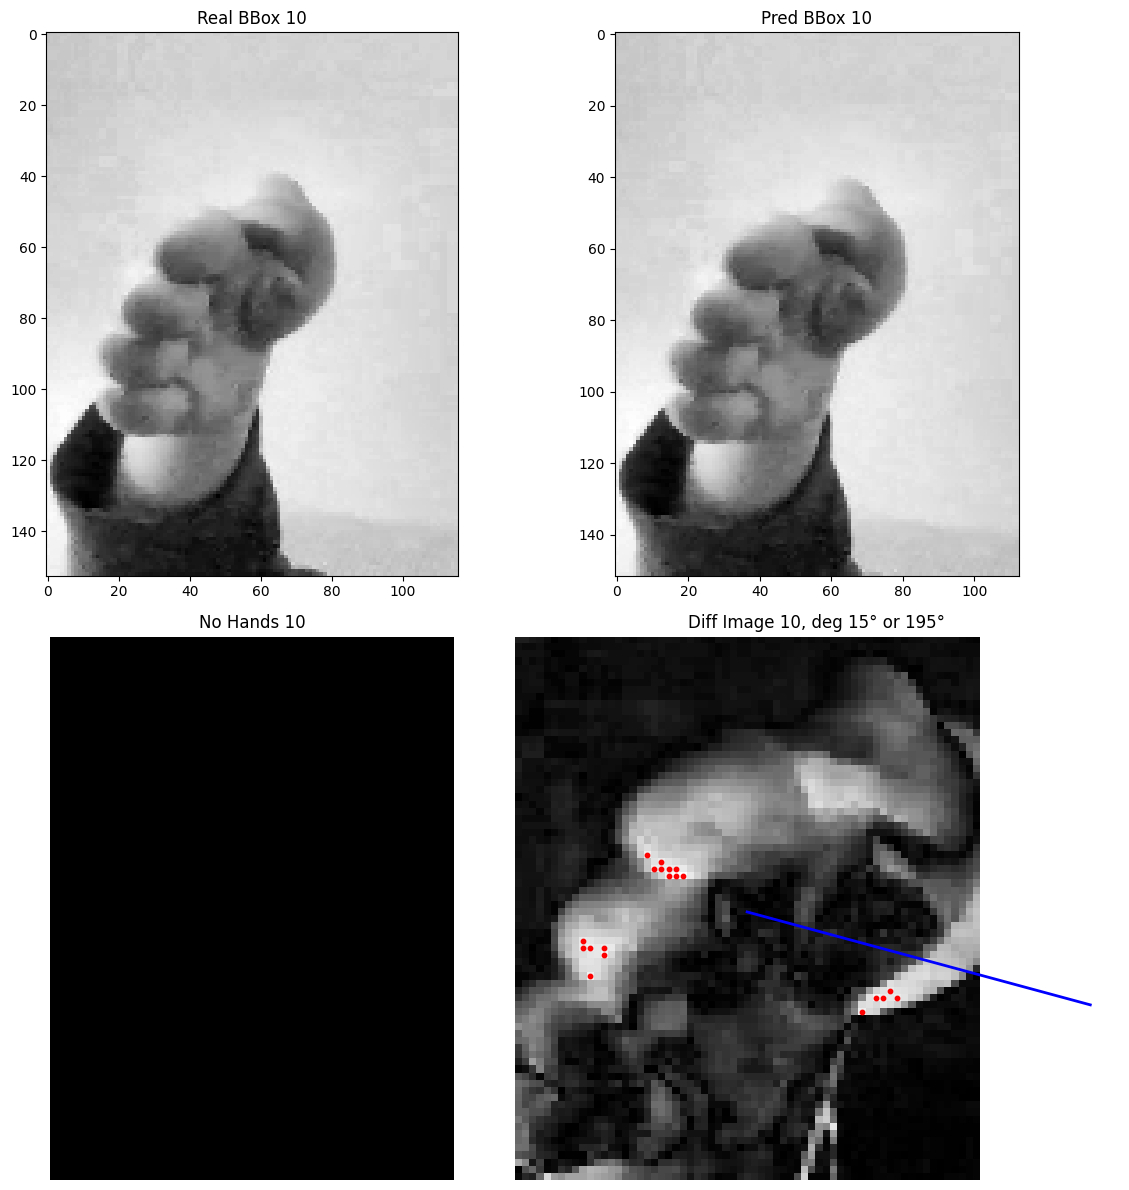

Angle LR: 4.936240124180386° or 184.9362401241804°
No hands detected for image 11!


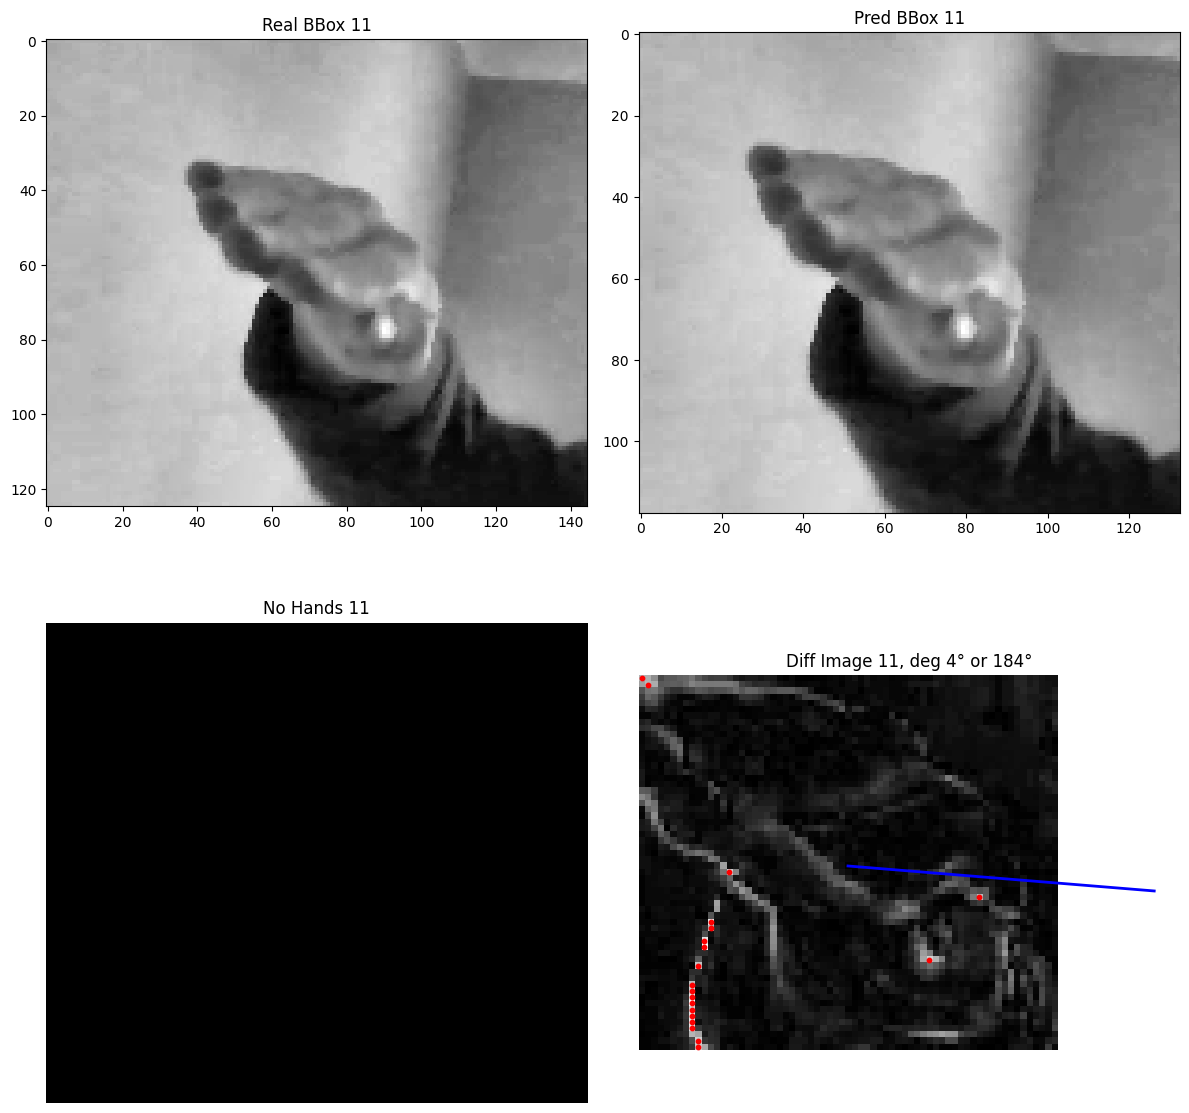

Angle LR: 157.21257978663044° or 337.21257978663044°
No hands detected for image 12!


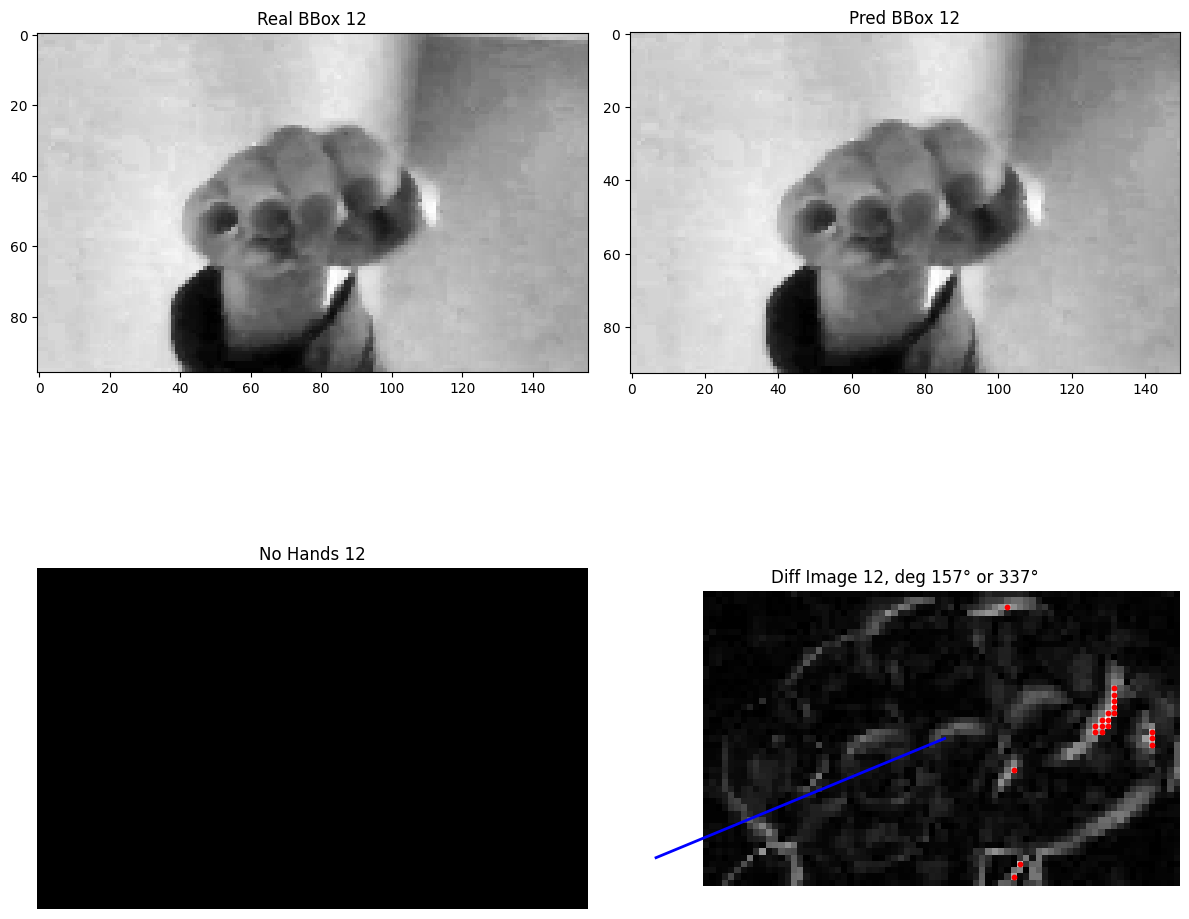

Angle LR: 43.29788436794917° or 223.29788436794917°
No hands detected for image 13!


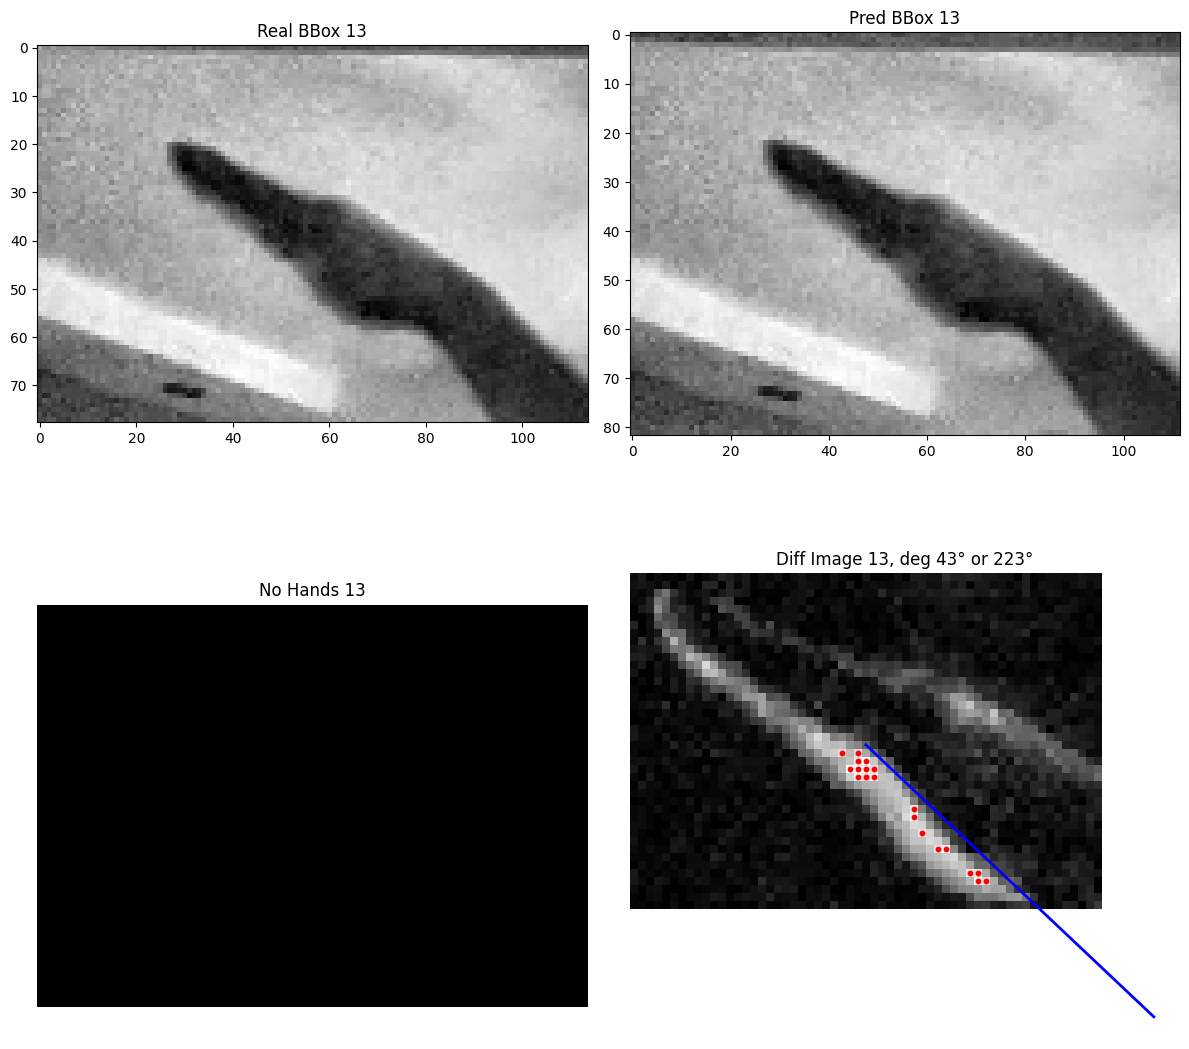

Angle LR: 147.84352550686313° or 327.8435255068631°
Hands detected for image 14!
Angle GOOGLE: 308°


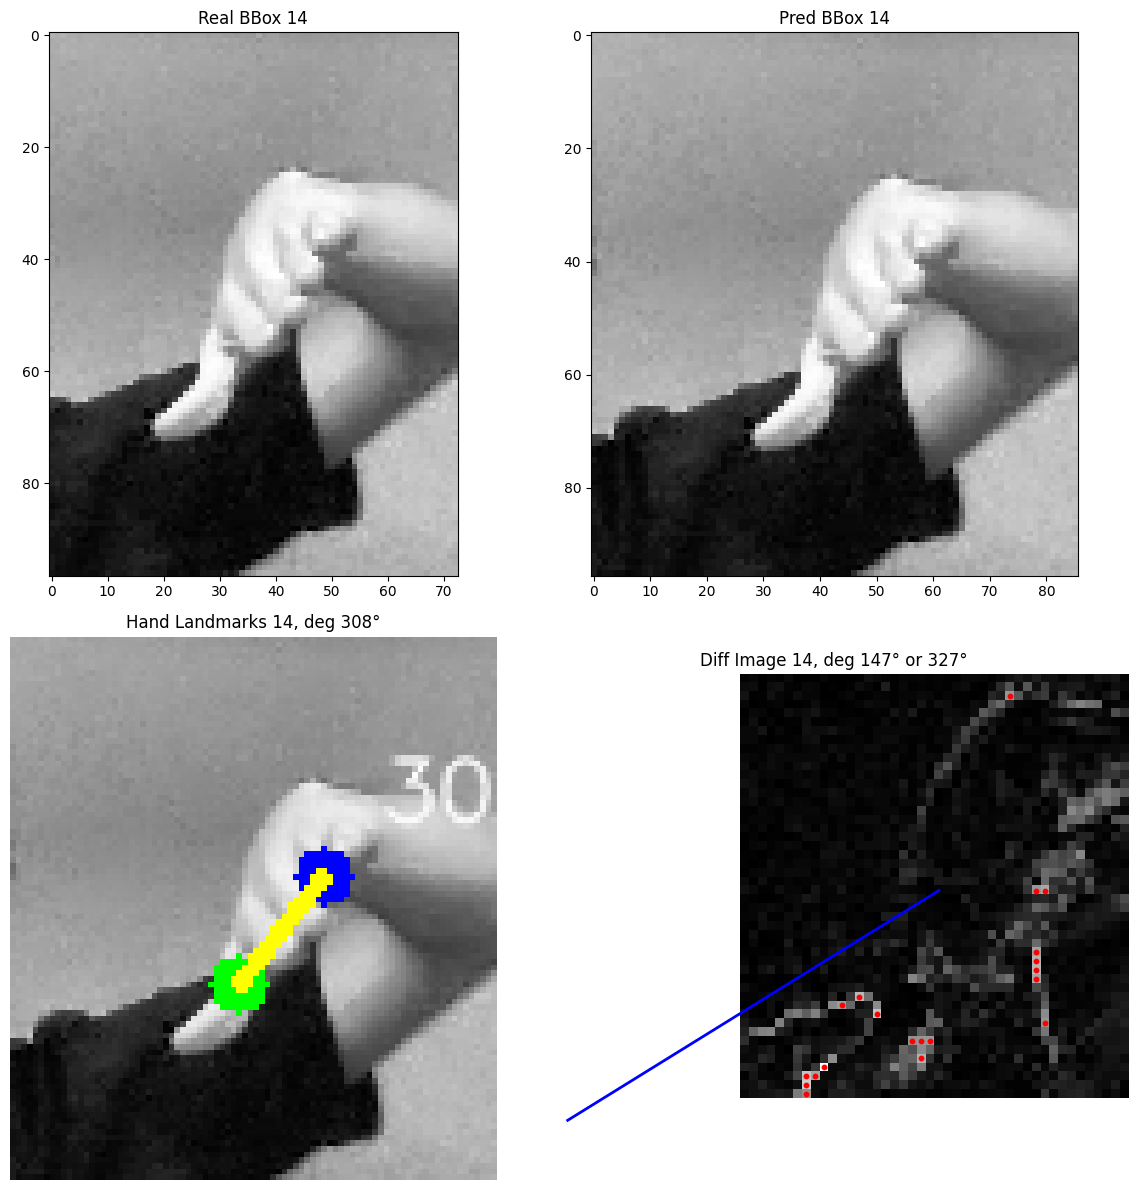

Angle LR: 10.825978548684592° or 190.8259785486846°
No hands detected for image 15!


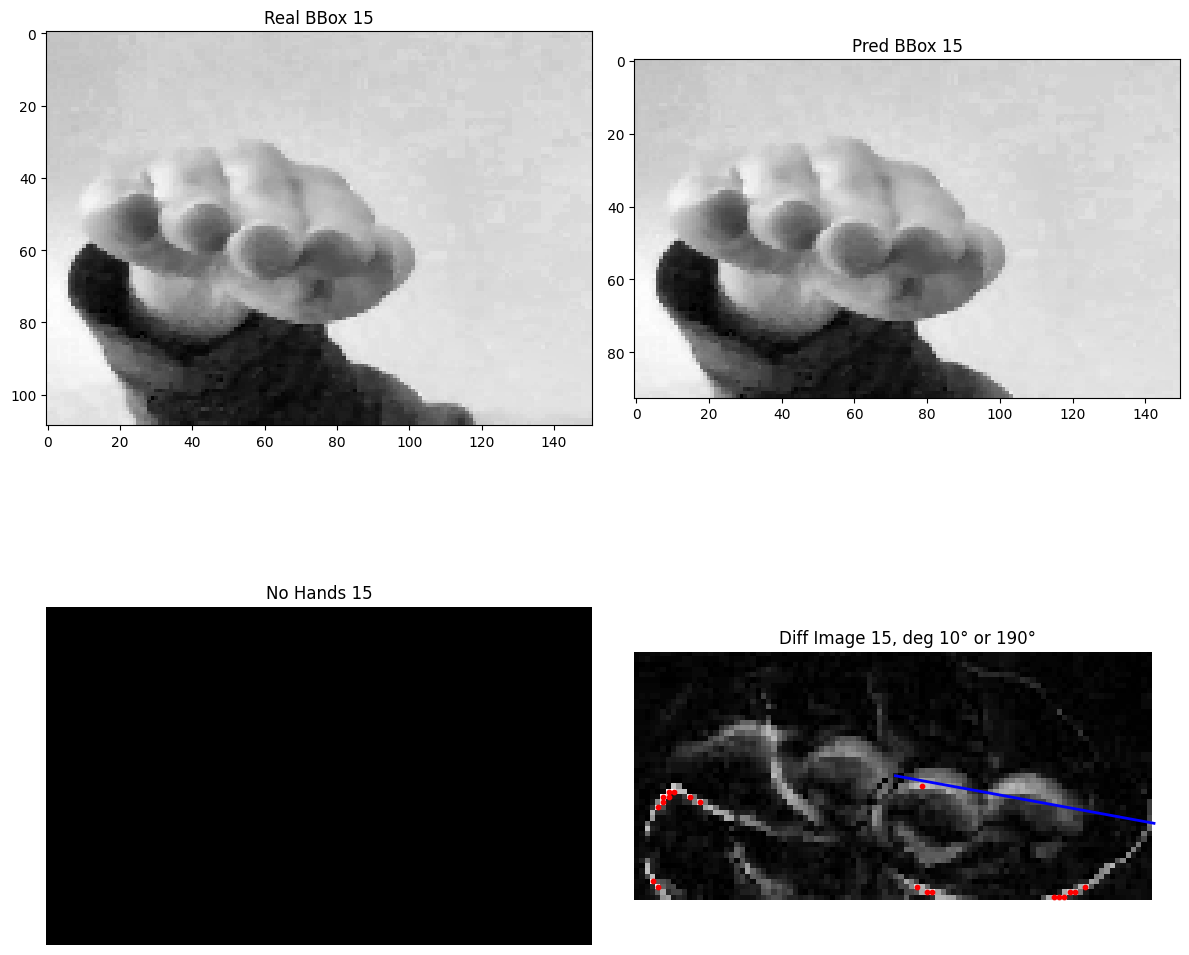

Angle LR: 19.613925202841873° or 199.61392520284187°
No hands detected for image 16!


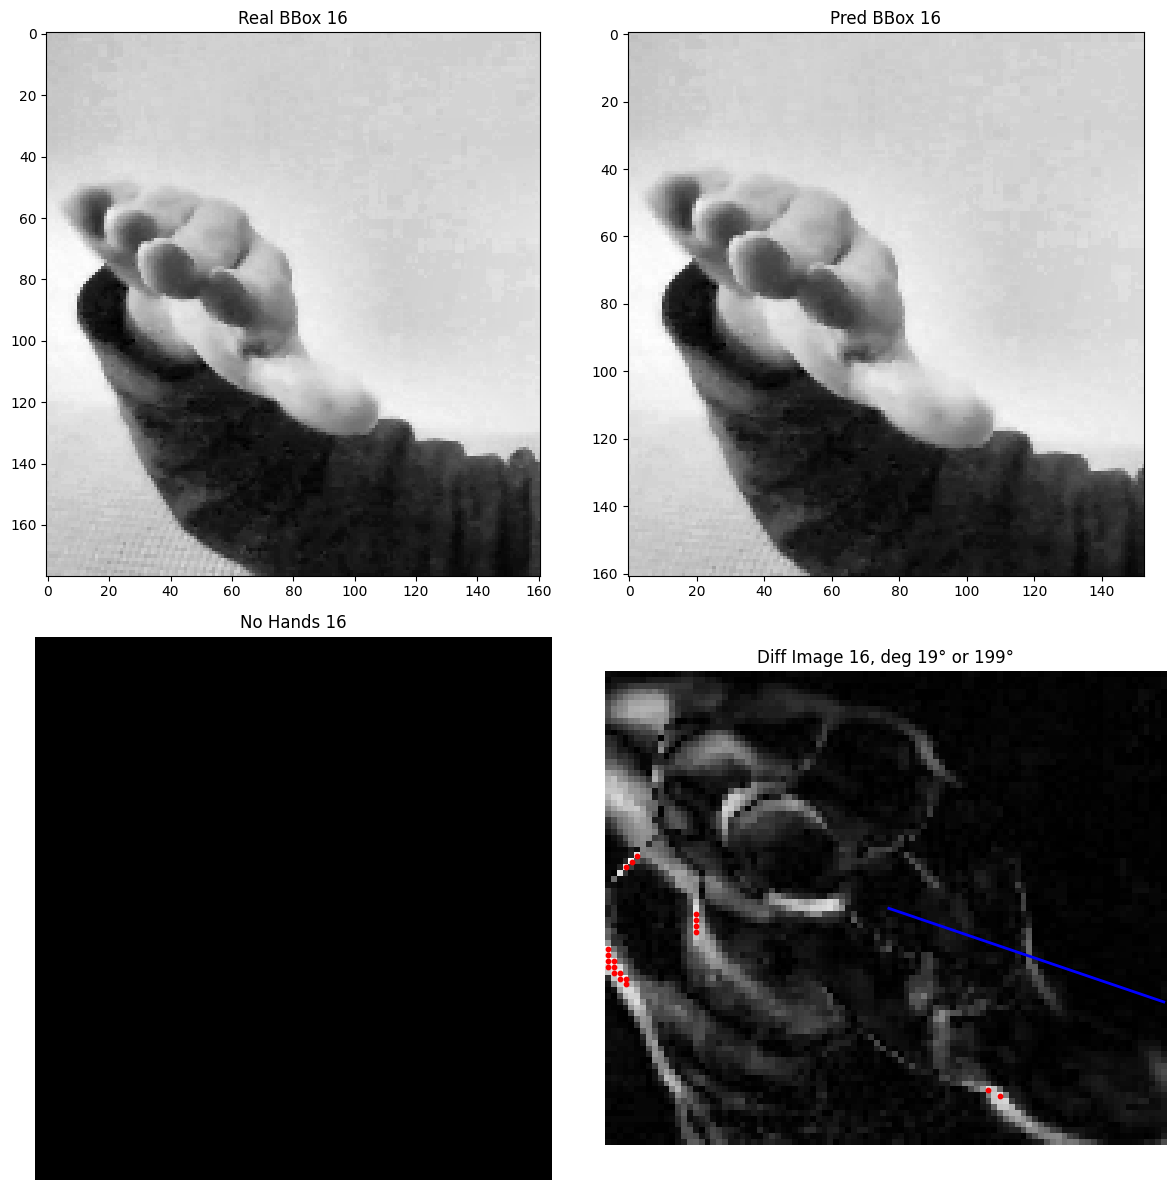

AVG INFERENCE TIME: 0.23476986587047577 s
Google angle activation: 31.25 %
LR angle activation: 68.75 %
Based on 16 samples.


In [97]:
### UMJESTO K TOP, svi iznad praga
# BEZ EXPANZIJE ZA LR


import mediapipe as mp
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.linear_model import LinearRegression

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Initialize MediaPipe Hands object
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.2)

EXPAND_FACTOR = 0.5
avg_time = 0
num_valid_samples = 0

# Filter data where np.argmax(y_test[i][0:4]) == 0
filtered_indices = [i for i in range(len(y_test)) if np.argmax(y_test[i][0:4]) == 0]
num_images = len(filtered_indices)  # Total number of valid images
num_rows = 2  # Two rows for plots
num_cols = 2  # Two columns for plots

K = 20  # Number of top pixels to consider

google_track = []

for idx, i in enumerate(filtered_indices):  # Process all filtered images
    plt.figure(figsize=(12, 6 * num_rows))  # Adjust the figure size to accommodate all the plots
    num_valid_samples += 1

    # Image1 and its prediction
    image1 = X_test[i, ..., 0][np.newaxis, ..., np.newaxis]
    start_time = time.time()
    pred_output = model2.predict(image1, verbose=0)
    end_time = time.time() - start_time
    avg_time += end_time

    # Image2 for the 4th plot
    image2 = X_test[i, ..., 1][np.newaxis, ..., np.newaxis]

    # Prepare images
    image1 = image1 * 255
    image2 = image2 * 255
    img1 = Image.fromarray(image1[0, ..., 0].astype(np.uint8))
    img2 = Image.fromarray(image2[0, ..., 0].astype(np.uint8))

    # Real bbox cropping
    center_x, center_y, width, height = y_test[i][4:]
    left, top = int(center_x - width / 2) - int(width * EXPAND_FACTOR), int(center_y - height / 2) - int(height * EXPAND_FACTOR)
    right, bottom = int(center_x + width / 2) + int(width * EXPAND_FACTOR), int(center_y + height / 2) + int(height * EXPAND_FACTOR)
    real_cropped_image = img1.crop((max(0, left), max(0, top), min(img1.width, right), min(img1.height, bottom)))
    real_cropped_image_np = np.array(real_cropped_image)

    # Predicted bbox cropping for image1
    center_x, center_y, width, height = pred_output[0][4:]
    left, top = int(center_x - width / 2) - int(width * EXPAND_FACTOR), int(center_y - height / 2) - int(height * EXPAND_FACTOR)
    right, bottom = int(center_x + width / 2) + int(width * EXPAND_FACTOR), int(center_y + height / 2) + int(height * EXPAND_FACTOR)
    pred_cropped_image = img1.crop((max(0, left), max(0, top), min(img1.width, right), min(img1.height, bottom)))
    pred_cropped_image_np = np.array(pred_cropped_image)

    # Predicted bbox cropping for image2
    left, top = int(center_x - width / 2), int(center_y - height / 2)
    right, bottom = int(center_x + width / 2), int(center_y + height / 2)
    pred_cropped_image2 = img2.crop((max(0, left), max(0, top), min(img2.width, right), min(img2.height, bottom)))
    pred_cropped_image2_np = np.array(pred_cropped_image2)

    #### MOVM CROP ####
    if pred_cropped_image2_np.ndim == 3:
        diff_image = pred_cropped_image2_np[..., 0]  # Assuming grayscale image in the first channel
    else:
        diff_image = pred_cropped_image2_np  # If already 2D, no change

    # Find the top K pixel intensities and their coordinates
    flat_indices = np.argsort(diff_image.ravel())[::-1][:K]  # Indices of top K pixels
    coords = np.column_stack(np.unravel_index(flat_indices, diff_image.shape))  # Convert to 2D coordinates

    # Fit a linear regression model
    x_coords = coords[:, 1].reshape(-1, 1)  # Column vector for x-coordinates
    y_coords = coords[:, 0]  # Array for y-coordinates
    model = LinearRegression()
    model.fit(x_coords, y_coords)

    # Calculate the angle of the fitted line
    slope = model.coef_[0]
    lr_angle_rad = np.arctan(slope)
    lr_angle_deg = np.degrees(lr_angle_rad)

    # Adjust angle to [0, 360) range
    if lr_angle_deg < 0:
        lr_angle_deg += 180
    if lr_angle_deg >= 180:
        lr_angle_deg = 360 - lr_angle_deg

    print(f"Angle LR: {lr_angle_deg}° or {180 + lr_angle_deg}°")

    #############

    # Process Google Hand for image1
    image_np = cv2.cvtColor(pred_cropped_image_np, cv2.COLOR_RGB2BGR)
    results = hands.process(image_np)

    # Plotting each image in a 2x2 grid after printing
    plt.subplot(num_rows, num_cols, 1)  # First plot (Real BBox)
    plt.imshow(real_cropped_image_np, cmap='gray')
    plt.title(f"Real BBox {idx + 1}")
    #plt.axis('off')

    plt.subplot(num_rows, num_cols, 2)  # Second plot (Pred BBox)
    plt.imshow(pred_cropped_image_np, cmap='gray')
    plt.title(f"Pred BBox {idx + 1}")
    #plt.axis('off')

    plt.subplot(num_rows, num_cols, 3)  # Third plot (Hand landmarks or No Hands)
    if results.multi_hand_landmarks:
        google_track.append(1)
        print(f"Hands detected for image {idx + 1}!")
        for hand_landmarks in results.multi_hand_landmarks:
            landmark_8 = hand_landmarks.landmark[8]
            landmark_20 = hand_landmarks.landmark[20]

            h, w, _ = image_np.shape
            point_8 = (int(landmark_8.x * w), int(landmark_8.y * h))
            point_20 = (int(landmark_20.x * w), int(landmark_20.y * h))

            dx = point_20[0] - point_8[0]
            dy = point_20[1] - point_8[1]
            angle_rad = math.atan2(dy, dx)
            angle_deg = math.degrees(angle_rad)
            if angle_deg < 0:
                angle_deg += 360
            goog_angle_deg = int(round(angle_deg))

            print(f"Angle GOOGLE: {goog_angle_deg}°")

            cv2.putText(
                image_np,
                f"{goog_angle_deg}°",
                (point_20[0] + 10, point_20[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 255, 255),
                1,
                cv2.LINE_AA
            )
            cv2.circle(image_np, point_8, 5, (0, 255, 0), -1)
            cv2.circle(image_np, point_20, 5, (255, 0, 0), -1)
            cv2.line(image_np, point_8, point_20, (0, 255, 255), 2)

        plt.subplot(num_rows, num_cols, 3)  # Bottom-left for hand landmarks
        plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
        plt.title(f"Hand Landmarks {idx + 1}, deg {goog_angle_deg}°")
        plt.axis('off')
    else:
        google_track.append(0)
        print(f"No hands detected for image {idx + 1}!")
        plt.subplot(num_rows, num_cols, 3)
        plt.imshow(np.zeros_like(image_np), cmap='gray')
        plt.title(f"No Hands {idx + 1}")
        plt.axis('off')

    plt.subplot(num_rows, num_cols, 4)  # Fourth plot (Difference Image with Top K pixels)
    plt.imshow(pred_cropped_image2_np, cmap='gray')
    plt.title(f"Diff Image {idx + 1}, deg {int(lr_angle_deg)}° or {180 + int(lr_angle_deg)}°")

    # Draw line based on lr_angle_deg
    # Get image center coordinates
    center_y, center_x = diff_image.shape[0] // 2, diff_image.shape[1] // 2
    line_length = 50  # Length of the line to draw

    # Calculate end point of the line using angle
    end_x = int(center_x + line_length * np.cos(np.radians(lr_angle_deg)))
    end_y = int(center_y + line_length * np.sin(np.radians(lr_angle_deg)))

    # Draw the line
    plt.plot([center_x, end_x], [center_y, end_y], color='blue', linewidth=2)

    # Mark top K pixels with red dots
    for coord in coords:
        plt.scatter(coord[1], coord[0], c='red', s=10)  # Mark top K pixels with red dots

    plt.axis('off')

    # Display all plots
    plt.tight_layout()
    plt.show()

# Print the average inference time
if num_valid_samples > 0:
    print("AVG INFERENCE TIME:", avg_time / num_valid_samples, "s")
else:
    print("No valid samples found!")


srv = np.mean(google_track)
print("Google angle activation:", srv *100, "%")
print("LR angle activation:", (1 - srv)*100, "%")
print("Based on", len(google_track), "samples.")
